In [69]:
import pandas as pd
import os

model_name = "geosse"
trees_directory = "trees/"
num_states = 3

# part of the relative path for writing down the output files
chemin = './trained_models/SS/' + model_name + '/'

# the suffix of output files
expname='geosse_6651'

In [2]:
import os
import numpy as np
from ete3 import Tree

class TreeEncoder:

    def encode_tree(self, tree_str):
        """
        Encode the tree structure into a format suitable for input into the neural network.
        """
        # Check if the tree is already encoded
        csv_file = tree_str[:-4] + '.csv'
        if os.path.exists(csv_file):
            return csv_file
        # Call the external script to get CDV encoding
        cmd = f"python -m CDV_full_tree -t {tree_str} -f {csv_file}" # > {tree_str[:-4]}.csv"
        os.system(cmd)
        

    def encode_all_trees(self, trees_directory):
        """
        Encode all the trees in the given directory.
        """
        tree_files = [os.path.join(trees_directory, file) for file in os.listdir(trees_directory) if file.endswith('.nwk')]
        for tree_file in tree_files:
            print(tree_file)
            self.encode_tree(tree_file)


In [3]:
import sys

encoder = TreeEncoder()
encoded_trees = encoder.encode_all_trees(trees_directory)

trees/bd.nwk
trees/bisse.nwk
trees/bisseness.nwk
trees/classe.nwk
trees/classe_2.nwk
trees/geosse.nwk
trees/musse.nwk
trees/musse_90614.nwk
trees/quasse.nwk


Check if the musse.csv is empty, in that case run
* python -m CDV_full_tree -t trees/musse.nwk -f trees/musse.csv

from linux terminal!

In [70]:
import pandas as pd
import os

# Load parameter values as a dataframe
tree_files = [os.path.join(trees_directory, file) for file in os.listdir(trees_directory) if file.endswith('.nwk')]


if model_name == "bd":
    column_names = ['lambda', 'mu']
elif model_name == "bisse":
    column_names = ['lambda1', 'lambda2', 'mu1', 'mu2', 'q12', 'q21']
elif model_name == "musse":
    '''
    λ1, . . . , λK, µ1, . . . , µK, qij
    Generalizing BiSSE to K
    character states with constant
    rates.
    '''
    if num_states == 3:
        column_names = ['lambda1', 'lambda2', 'lambda3', 'mu1', 'mu2', 'mu3', 'q12', 'q13', 'q21', 'q23', 'q31', 'q32']
    elif num_states == 4:
        column_names = ['lambda1', 'lambda2', 'lambda3', 'lambda4', 'mu1', 'mu2', 'mu3', 'mu4', 'q12', 'q13', 'q14', 'q21', 'q23', 'q24', 'q31', 'q32', 'q34', 'q41', 'q42', 'q43']
    else:
        print("Not implemented for more than 4 states")
elif model_name == "geosse":
    '''
    sA, sB, sAB, xA, xB, dA, dB    
    Accounts for geographical
    considerations with constant
    rates of speciation, extinction,
    and dispersal.'''
    column_names = ['sA', 'sB', 'sAB', 'xA', 'xB', 'dA', 'dB']
elif model_name == "bisseness":
    '''
    λ0, λ1, µ0, µ1, q12, q21, p0c, p0a, p1c, p1a
    Estimates rates of change occurring along lineages and
    probabilities of change during
    speciation.
    '''
    column_names = ['lambda1', 'lambda2', 'mu1', 'mu2', 'q12', 'q21', 'p1c', 'p1a', 'p2c', 'p2a']
elif model_name == "classe":
    '''
    λklm (where 1 ≤ k, l, m ≤ n),
    µk (where 1 ≤ k ≤ n),
    qlm (where 1 ≤ l ̸= m ≤ n)
    Distinguishes between anagenetic and cladogenetic speciation with variable rates.
    There will be n^2 cladogenesis rates and n extinction rates
    plus n(n-1) transition rates, making a total of n^2+n+n(n-1) parameters.
    
    Two character states:
    • λ111: Rate of cladogenesis generating progeny inheriting the first character
    state if the parent already possessed said attribute.
    • λ112: Rate of cladogenesis leading to descendants adopting the second
    character state when parents initially bore the initial feature.
    • λ122: Analogous scenario but with reversed roles in character acquisition
    order.
    3
    Figure 2: Anagenesis and Cladogenesis.
    • λ211: Another case wherein children adopt the first characteristic after the
    parent had shifted to the second configuration.
    • λ212: Identical context as above except the final outcome reflects the emergence of the second character state in offspring.
    • λ222: Parallel situation to the preceding cases yet with both parents and
    descendants uniformly exhibiting the latter trait.
    • µ1: Extinction rate attributed to the primary character state.
    • µ2: Loss rate ascribed to the secondary character state.
    • q12: Shift rate towards obtaining the second character state starting from
    the first.
    • q21: Reverse transformation rate moving away from the first characteristic
    toward attaining the second.
    '''
    if num_states == 2:
        column_names = ['lambda111', 'lambda112', 'lambda122', 'lambda211', 'lambda212', 'lambda222', 'mu1', 'mu2', 'q12', 'q21']
    else:
        print("Not implemented yet for more than 2 states")
        
    


def process_params(param_file):
    # Reads the parameter file and saves the values in a csv file, one tree per row.
    # If the parameter file is already in the csv format, return
    if param_file.endswith('.csv'):
        return
    with open(param_file, 'r') as f:
        lines = f.readlines()
    param_values = []
    for line in lines:
        if model_name == 'musse' or model_name == 'classe':
            if line.startswith('num_states'):
                param_values.append([])
            else:
                param_values[-1].append(line.split()[1])
        elif model_name == 'bisse' or model_name == 'bisseness':
            if line.startswith('lambda1'):
                param_values.append([])
            param_values[-1].append(line.split()[1])
        elif model_name == 'geosse':
            if line.startswith('sp_a'):
                param_values.append([])
            param_values[-1].append(line.split()[1])
        elif model_name == 'bd':
            if line.startswith('lambda'):
                param_values.append([])
            param_values[-1].append(line.split()[1])
        else:
            print("Model not implemented")
    param_df = pd.DataFrame(param_values)
    param_df.to_csv(param_file + '.csv', sep='\t', header=False, index=False)
        
        
    
    
param_file = trees_directory + model_name + '.params'
process_params(param_file)


cutoff = 0.8  # Number of train trees
param = pd.read_csv(param_file + '.csv' , sep='\t', header=None)

# loading tree encodings/representations
# encoding has the following structure: 1 value of tree height, 500 values for tip states ('1' or '2')
# 1 value for tree height and 500 values for internal node heights
# + 2 values for nb of tips of each type (to be removed) and 1 value of rescaling (removed, but stocked for rescaling predicted values back to the original scale)

# split the encoding into train and test (cutoff is 0.8% of the data)
# read csv and know that there are empty rows for each row of the dataframe
encoding = pd.read_csv(trees_directory + model_name + '_ss.csv', sep='\t', header=None, index_col=0)

# Loop over the rows of the dataframe and if you find NaN values, remove the corresponding row from the dataframe and from the parameter dataframe
lines_to_remove = []
for i in range(encoding.shape[0]):
    if encoding.iloc[i].isnull().values.any():
        lines_to_remove.append(i)
        print("Removing row ", i)
        
encoding = encoding.dropna()
param = param.drop(lines_to_remove)
# read model.sizes file and remove the corresponding lines from the dataframe
#model_sizes = pd.read_csv(trees_directory + model_name + '.sizes', sep='\t', header=None)
#model_sizes = model_sizes.drop(lines_to_remove)
        
# Check that the number of rows is correct
assert encoding.shape[0] == param.shape[0]
        
        
        
cutoff = int(cutoff * param.shape[0])

param_train = param.iloc[:cutoff, :]
param_test = param.iloc[cutoff:, :]

print(param_train.columns)
print(column_names)

# Check that the number of columns is correct
assert param_train.shape[1] == len(column_names)

print(param_train.shape)
print(param_test.shape)


def rename_columns(df, names):
    df = df.rename(columns={i: names[i] for i in df.columns})
    return df

param_train = rename_columns(param_train, column_names)
param_test = rename_columns(param_test, column_names)

encoding_train = encoding.iloc[:cutoff, :]
encoding_test = encoding.iloc[cutoff:, :]

print(encoding_train.shape)
print(encoding_test.shape)

print("Number of trees in parameters file: ", param.shape[0])
print("Number of trees in encoding file: ", encoding.shape[0])

if (param.shape[0] != encoding.shape[0]):
    print("Number of trees in parameters file and encoding file do not match, taking the last common number of trees")
    encoding = encoding.iloc[-param.shape[0]:, :]
    encoding_train = encoding.iloc[:cutoff, :]
    encoding_test = encoding.iloc[cutoff:, :]
    print("Number of trees in encoding file: ", encoding.shape[0])

# make sure there is correspondance between indexes of dataframe with parameter values and encodings
encoding_train.index = param_train.index
encoding_test.index = param_test.index

# check
param_test

# check
print(encoding_test.shape)
print(param_train)

# check
encoding_test

Removing row  119
Removing row  321
Removing row  365
Removing row  417
Removing row  786
Removing row  893
Removing row  940
Removing row  1050
Removing row  1151
Removing row  1403
Removing row  1540
Removing row  1761
Removing row  1781
Removing row  1811
Removing row  1835
Removing row  1902
Removing row  2048
Removing row  2092
Removing row  2149
Removing row  2227
Removing row  2311
Removing row  2361
Removing row  2823
Removing row  3118
Removing row  3180
Removing row  3209
Removing row  3538
Removing row  3586
Removing row  3694
Removing row  3913
Removing row  4044
Removing row  4208
Removing row  4356
Removing row  4459
Removing row  4479
Removing row  4706
Removing row  4781
Removing row  4951
Removing row  5162
Removing row  5219
Removing row  5465
Removing row  5519
Removing row  5528
Removing row  5531
Removing row  5576
Removing row  5597
Removing row  5599
Removing row  5839
Removing row  5841
Removing row  5861
Removing row  6018
Removing row  6111
Removing row  6227


,1,2,3,4,5,6,7,8,9,10,...,89,90,91,92,93,94,95,96,97,98
5312,14.386656,1.0,0.670836,1.068993,0.915312,0.610170,0.927699,1.108785,0.688358,1.432987,...,2.062847,2.569696,2.975890,3.598926,4.359528,5.328370,8.721762,2.830389,886,0.936675
5313,9.569647,1.0,0.611280,1.205895,0.935040,0.521447,1.290041,0.585296,0.597212,0.199861,...,2.101303,2.554947,2.844157,3.401002,3.678572,4.187276,6.115799,1.701316,154,0.706498
5314,12.890357,1.0,0.619750,1.255993,0.950563,0.573814,1.184735,0.846040,0.559874,0.784019,...,2.230137,2.503300,2.884356,3.502680,4.047147,4.840427,9.462089,2.398962,530,1.176002
5315,14.215766,1.0,0.681700,0.969862,0.950424,0.649214,0.902272,0.999505,1.352600,0.409668,...,2.106904,2.375940,2.643377,3.039638,3.543938,4.406599,9.060112,2.251107,1000,0.617350
5316,14.603316,1.0,0.663721,1.173882,0.943543,0.632148,1.083175,0.678256,0.555976,0.351628,...,2.118699,2.356244,2.901625,3.150469,3.848793,5.402190,10.620910,2.900031,983,1.287072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6644,12.610891,1.0,0.700727,1.000156,0.979668,0.676855,0.935587,1.040769,0.948817,0.454536,...,2.252661,2.513028,2.906880,3.373710,3.974795,4.708974,8.794529,2.301274,657,0.559197
6645,11.717041,1.0,0.671819,1.078847,0.961813,0.619916,1.015169,0.801291,0.591759,0.498329,...,2.156622,2.634064,2.961362,3.248750,3.642228,4.595279,8.489383,2.074475,807,0.441024
6646,12.295280,1.0,0.681605,0.993155,0.947978,0.648864,0.886246,1.291318,1.359982,0.940671,...,2.317274,2.734468,3.034364,3.374445,3.859273,4.714192,8.213349,1.809032,943,0.531908
6648,11.109706,1.0,0.686087,1.014435,0.993296,0.675947,0.927396,1.053497,0.666537,1.475998,...,2.297550,2.614682,2.751492,2.961706,3.356225,4.086517,5.450368,1.046927,386,0.503454


In [71]:
#correctly reshape parameters (rescaling) and encodings (remove nb of each type + rescale factor):

### TRAINING SET: PARAMETER VALUES
# rescaling factor
print(len(encoding_train.columns))
# get the normalization factor that is stored in the last column of the encoding
param_train['norm_factor'] = encoding_train.iloc[:, -1]
encoding_train = encoding_train.drop(encoding_train.columns[-1], axis =1)


print(param_train['norm_factor'])

# add to the parameter dataframe the net rate values, that are the difference between lambda and mu for each state
# and rescale target values according to scaling factor
if model_name == 'bd':
    param_train['mu_rescaled'] = param_train['mu']*param_train['norm_factor']
    param_train['lambda_rescaled'] = param_train['lambda']*param_train['norm_factor']

elif model_name == 'bisse':
    param_train['mu1_rescaled'] = param_train['mu1']*param_train['norm_factor']
    param_train['mu2_rescaled'] = param_train['mu2']*param_train['norm_factor']
    param_train['lambda1_rescaled'] = param_train['lambda1']*param_train['norm_factor']
    param_train['lambda2_rescaled'] = param_train['lambda2']*param_train['norm_factor']
    param_train['q12_rescaled'] = param_train['q12']*param_train['norm_factor']
    param_train['q21_rescaled'] = param_train['q21']*param_train['norm_factor']

elif model_name == 'musse':
    if num_states == 3:
        param_train['mu1_rescaled'] = param_train['mu1']*param_train['norm_factor']
        param_train['mu2_rescaled'] = param_train['mu2']*param_train['norm_factor']
        param_train['mu3_rescaled'] = param_train['mu3']*param_train['norm_factor']
        param_train['lambda1_rescaled'] = param_train['lambda1']*param_train['norm_factor']
        param_train['lambda2_rescaled'] = param_train['lambda2']*param_train['norm_factor']
        param_train['lambda3_rescaled'] = param_train['lambda3']*param_train['norm_factor']
        param_train['q12_rescaled'] = param_train['q12']*param_train['norm_factor']
        param_train['q13_rescaled'] = param_train['q13']*param_train['norm_factor']
        param_train['q21_rescaled'] = param_train['q21']*param_train['norm_factor']
        param_train['q23_rescaled'] = param_train['q23']*param_train['norm_factor']
        param_train['q31_rescaled'] = param_train['q31']*param_train['norm_factor']
        param_train['q32_rescaled'] = param_train['q32']*param_train['norm_factor']
        
    elif num_states == 4:
        param_train['mu1_rescaled'] = param_train['mu1']*param_train['norm_factor']
        param_train['mu2_rescaled'] = param_train['mu2']*param_train['norm_factor']
        param_train['mu3_rescaled'] = param_train['mu3']*param_train['norm_factor']
        param_train['mu4_rescaled'] = param_train['mu4']*param_train['norm_factor']
        param_train['lambda1_rescaled'] = param_train['lambda1']*param_train['norm_factor']
        param_train['lambda2_rescaled'] = param_train['lambda2']*param_train['norm_factor']
        param_train['lambda3_rescaled'] = param_train['lambda3']*param_train['norm_factor']
        param_train['lambda4_rescaled'] = param_train['lambda4']*param_train['norm_factor']
        param_train['q12_rescaled'] = param_train['q12']*param_train['norm_factor']
        param_train['q13_rescaled'] = param_train['q13']*param_train['norm_factor']
        param_train['q14_rescaled'] = param_train['q14']*param_train['norm_factor']
        param_train['q21_rescaled'] = param_train['q21']*param_train['norm_factor']
        param_train['q23_rescaled'] = param_train['q23']*param_train['norm_factor']
        param_train['q24_rescaled'] = param_train['q24']*param_train['norm_factor']
        param_train['q31_rescaled'] = param_train['q31']*param_train['norm_factor']
        param_train['q32_rescaled'] = param_train['q32']*param_train['norm_factor']
        param_train['q34_rescaled'] = param_train['q34']*param_train['norm_factor']
        param_train['q41_rescaled'] = param_train['q41']*param_train['norm_factor']
        param_train['q42_rescaled'] = param_train['q42']*param_train['norm_factor']
        param_train['q43_rescaled'] = param_train['q43']*param_train['norm_factor']
    else:
        print("Not implemented for more than 4 states")

elif model_name == 'geosse':
    param_train['xA_rescaled'] = param_train['xA']*param_train['norm_factor']
    param_train['xB_rescaled'] = param_train['xB']*param_train['norm_factor']
    param_train['sA_rescaled'] = param_train['sA']*param_train['norm_factor']
    param_train['sB_rescaled'] = param_train['sB']*param_train['norm_factor']
    param_train['sAB_rescaled'] = param_train['sAB']*param_train['norm_factor']
    param_train['dA_rescaled'] = param_train['dA']*param_train['norm_factor']
    param_train['dB_rescaled'] = param_train['dB']*param_train['norm_factor']

elif model_name == 'bisseness':
    param_train['mu1_rescaled'] = param_train['mu1']*param_train['norm_factor']
    param_train['mu2_rescaled'] = param_train['mu2']*param_train['norm_factor']
    param_train['q12_rescaled'] = param_train['q12']*param_train['norm_factor']
    param_train['q21_rescaled'] = param_train['q21']*param_train['norm_factor']
    param_train['p1c_rescaled'] = param_train['p1c']*param_train['norm_factor']
    param_train['p1a_rescaled'] = param_train['p1a']*param_train['norm_factor']
    param_train['p2c_rescaled'] = param_train['p2c']*param_train['norm_factor']
    param_train['p2a_rescaled'] = param_train['p2a']*param_train['norm_factor']
    param_train['lambda1_rescaled'] = param_train['lambda1']*param_train['norm_factor']
    param_train['lambda2_rescaled'] = param_train['lambda2']*param_train['norm_factor']
    

elif model_name == 'classe':
    param_train['mu11_rescaled'] = param_train['mu11']*param_train['norm_factor']
    param_train['mu12_rescaled'] = param_train['mu12']*param_train['norm_factor']
    param_train['mu22_rescaled'] = param_train['mu22']*param_train['norm_factor']
    param_train['mu21_rescaled'] = param_train['mu21']*param_train['norm_factor']
    



### TESTING SET: PARAMETER VALUES
# rescaling factor
param_test['norm_factor'] = encoding_test.iloc[:, -1]
encoding_test = encoding_test.drop(encoding_test.columns[-1], axis =1)

if model_name == 'bd':
    param_test['mu_rescaled'] = param_test['mu']*param_test['norm_factor']
    param_test['lambda_rescaled'] = param_test['lambda']*param_test['norm_factor']

elif model_name == 'bisse':
    param_test['mu1_rescaled'] = param_test['mu1']*param_test['norm_factor']
    param_test['mu2_rescaled'] = param_test['mu2']*param_test['norm_factor']
    param_test['lambda1_rescaled'] = param_test['lambda1']*param_test['norm_factor']
    param_test['lambda2_rescaled'] = param_test['lambda2']*param_test['norm_factor']
    param_test['q12_rescaled'] = param_test['q12']*param_test['norm_factor']
    param_test['q21_rescaled'] = param_test['q21']*param_test['norm_factor']

elif model_name == 'musse':
    if num_states == 3:
        param_test['mu1_rescaled'] = param_test['mu1']*param_test['norm_factor']
        param_test['mu2_rescaled'] = param_test['mu2']*param_test['norm_factor']
        param_test['mu3_rescaled'] = param_test['mu3']*param_test['norm_factor']
        param_test['lambda1_rescaled'] = param_test['lambda1']*param_test['norm_factor']
        param_test['lambda2_rescaled'] = param_test['lambda2']*param_test['norm_factor']
        param_test['lambda3_rescaled'] = param_test['lambda3']*param_test['norm_factor']
        param_test['q12_rescaled'] = param_test['q12']*param_test['norm_factor']
        param_test['q13_rescaled'] = param_test['q13']*param_test['norm_factor']
        param_test['q21_rescaled'] = param_test['q21']*param_test['norm_factor']
        param_test['q23_rescaled'] = param_test['q23']*param_test['norm_factor']
        param_test['q31_rescaled'] = param_test['q31']*param_test['norm_factor']
        param_test['q32_rescaled'] = param_test['q32']*param_test['norm_factor']
        
    elif num_states == 4:
        param_test['mu1_rescaled'] = param_test['mu1']*param_test['norm_factor']
        param_test['mu2_rescaled'] = param_test['mu2']*param_test['norm_factor']
        param_test['mu3_rescaled'] = param_test['mu3']*param_test['norm_factor']
        param_test['mu4_rescaled'] = param_test['mu4']*param_test['norm_factor']
        param_test['lambda1_rescaled'] = param_test['lambda1']*param_test['norm_factor']
        param_test['lambda2_rescaled'] = param_test['lambda2']*param_test['norm_factor']
        param_test['lambda3_rescaled'] = param_test['lambda3']*param_test['norm_factor']
        param_test['lambda4_rescaled'] = param_test['lambda4']*param_test['norm_factor']
        param_test['q12_rescaled'] = param_test['q12']*param_test['norm_factor']
        param_test['q13_rescaled'] = param_test['q13']*param_test['norm_factor']
        param_test['q14_rescaled'] = param_test['q14']*param_test['norm_factor']
        param_test['q21_rescaled'] = param_test['q21']*param_test['norm_factor']
        param_test['q23_rescaled'] = param_test['q23']*param_test['norm_factor']
        param_test['q24_rescaled'] = param_test['q24']*param_test['norm_factor']
        param_test['q31_rescaled'] = param_test['q31']*param_test['norm_factor']
        param_test['q32_rescaled'] = param_test['q32']*param_test['norm_factor']
        param_test['q34_rescaled'] = param_test['q34']*param_test['norm_factor']
        param_test['q41_rescaled'] = param_test['q41']*param_test['norm_factor']
        param_test['q42_rescaled'] = param_test['q42']*param_test['norm_factor']
        param_test['q43_rescaled'] = param_test['q43']*param_test['norm_factor']
    else:
        print("Not implemented for more than 4 states")

elif model_name == 'geosse':
    param_test['xA_rescaled'] = param_test['xA']*param_test['norm_factor']
    param_test['xB_rescaled'] = param_test['xB']*param_test['norm_factor']
    param_test['sA_rescaled'] = param_test['sA']*param_test['norm_factor']
    param_test['sB_rescaled'] = param_test['sB']*param_test['norm_factor']
    param_test['sAB_rescaled'] = param_test['sAB']*param_test['norm_factor']
    param_test['dA_rescaled'] = param_test['dA']*param_test['norm_factor']
    param_test['dB_rescaled'] = param_test['dB']*param_test['norm_factor']
    
elif model_name == 'bisseness':
    param_test['mu1_rescaled'] = param_test['mu1']*param_test['norm_factor']
    param_test['mu2_rescaled'] = param_test['mu2']*param_test['norm_factor']
    param_test['q12_rescaled'] = param_test['q12']*param_test['norm_factor']
    param_test['q21_rescaled'] = param_test['q21']*param_test['norm_factor']
    param_test['p1c_rescaled'] = param_test['p1c']*param_test['norm_factor']
    param_test['p1a_rescaled'] = param_test['p1a']*param_test['norm_factor']
    param_test['p2c_rescaled'] = param_test['p2c']*param_test['norm_factor']
    param_test['p2a_rescaled'] = param_test['p2a']*param_test['norm_factor']
    param_test['lambda1_rescaled'] = param_test['lambda1']*param_test['norm_factor']
    param_test['lambda2_rescaled'] = param_test['lambda2']*param_test['norm_factor']
    

elif model_name == 'classe':
    param_test['mu11_rescaled'] = param_test['mu11']*param_test['norm_factor']
    param_test['mu12_rescaled'] = param_test['mu12']*param_test['norm_factor']
    param_test['mu22_rescaled'] = param_test['mu22']*param_test['norm_factor']
    param_test['mu21_rescaled'] = param_test['mu21']*param_test['norm_factor']
    
    
#Reshape features
encoding_train = encoding_train.drop(encoding_train.columns[0], axis =1)
encoding_test = encoding_test.drop(encoding_test.columns[0], axis =1)

98
0       0.655152
1       1.179875
2       1.401543
3       0.593356
4       0.444662
          ...   
5307    0.597984
5308    0.927154
5309    0.604632
5310    0.824856
5311    0.864287
Name: norm_factor, Length: 5272, dtype: float64


In [72]:
encoding

,1,2,3,4,5,6,7,8,9,10,...,89,90,91,92,93,94,95,96,97,98
0,,,,,,,,,,,,,,,,,,,,,
0,18.728671,1.0,0.624013,1.318801,0.893862,0.518100,1.116847,1.226675,1.475894,0.834944,...,2.164852,2.601235,3.118113,3.668680,4.301841,5.051603,11.073535,2.693895,967,0.655152
1,13.409102,1.0,0.656235,1.194227,0.867925,0.539181,0.946936,0.943601,0.858631,0.443476,...,2.360642,2.796271,3.155591,3.730211,4.279917,5.112040,7.833965,2.349126,670,1.179875
2,33.909232,1.0,0.435487,2.789904,0.694025,0.337358,1.233355,0.000000,0.000000,0.000000,...,1.955726,2.436667,2.862821,4.117208,5.113251,7.410752,24.756313,10.506283,369,1.401543
3,8.934419,1.0,0.697709,0.849437,0.958021,0.664761,0.863968,0.651933,0.414785,0.259875,...,2.142632,2.431529,2.562306,2.868635,3.822096,4.504139,6.226816,1.657672,145,0.593356
4,12.554890,1.0,0.698020,0.976693,0.947530,0.648621,0.856880,0.913190,0.750961,0.526608,...,2.250655,2.552677,3.100417,3.596289,4.052928,5.009526,7.581649,2.105246,979,0.444662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6644,12.610891,1.0,0.700727,1.000156,0.979668,0.676855,0.935587,1.040769,0.948817,0.454536,...,2.252661,2.513028,2.906880,3.373710,3.974795,4.708974,8.794529,2.301274,657,0.559197
6645,11.717041,1.0,0.671819,1.078847,0.961813,0.619916,1.015169,0.801291,0.591759,0.498329,...,2.156622,2.634064,2.961362,3.248750,3.642228,4.595279,8.489383,2.074475,807,0.441024
6646,12.295280,1.0,0.681605,0.993155,0.947978,0.648864,0.886246,1.291318,1.359982,0.940671,...,2.317274,2.734468,3.034364,3.374445,3.859273,4.714192,8.213349,1.809032,943,0.531908


In [73]:
print(encoding_train.shape)
print(encoding_test.shape)

assert encoding_train.shape[1] == encoding_test.shape[1]

(5272, 96)
(1318, 96)


In [74]:
"""# Drop all information on tip states, excluding the tip state count
columns_to_drop = [i for i in range(2,1003)]
#Reshape features
encoding_train.drop(columns=columns_to_drop, axis=1, inplace=True)
encoding_test.drop(columns=columns_to_drop, axis=1, inplace=True)
#first_line = pd.DataFrame(table_eigenValues.columns).T"""

'# Drop all information on tip states, excluding the tip state count\ncolumns_to_drop = [i for i in range(2,1003)]\n#Reshape features\nencoding_train.drop(columns=columns_to_drop, axis=1, inplace=True)\nencoding_test.drop(columns=columns_to_drop, axis=1, inplace=True)\n#first_line = pd.DataFrame(table_eigenValues.columns).T'

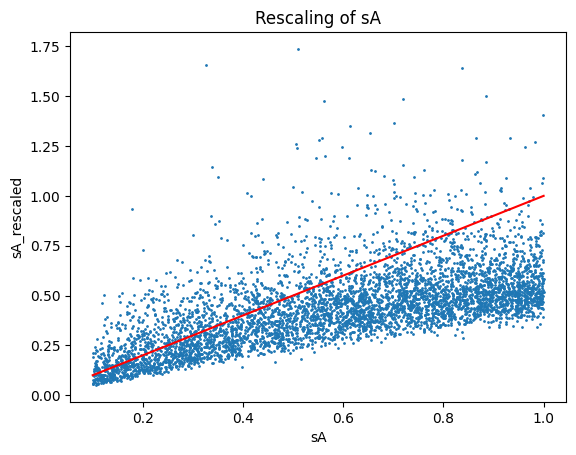

In [76]:
# plot lambda and lambda_rescaled in a way to see where it is rescaling
import matplotlib.pyplot as plt
plt.scatter(param_train['sA'], param_train['sA_rescaled'], s=1)
# add a diagonal line from min to max
plt.plot([min(param_train['sA']), max(param_train['sA'])], [min(param_train['sA']), max(param_train['sA'])], color='red')
plt.xlabel('sA')
plt.ylabel('sA_rescaled')
plt.title('Rescaling of sA')
plt.show()

In [77]:
encoding_train.shape

(5272, 96)

In [81]:
# Write to csv
param_train.to_csv(chemin + '/param_train' + expname + '.csv')
param_test.to_csv(chemin + '/param_test' + expname + '.csv')
encoding_train.to_csv(chemin + '/encoding_train' + expname + '.csv')
encoding_test.to_csv(chemin + '/encoding_test' + expname + '.csv')

In [82]:
import pandas as pd
import os



# Read the data
param_train = pd.read_csv(chemin + '/param_train' + expname + '.csv', index_col=0)
param_test = pd.read_csv(chemin + '/param_test' + expname + '.csv', index_col=0)
encoding_train = pd.read_csv(chemin + '/encoding_train' + expname + '.csv', index_col=0)
encoding_test = pd.read_csv(chemin + '/encoding_test' + expname + '.csv', index_col=0)

In [83]:
#Choice of the parameters to predict

if model_name == "musse":
    if num_states == 3:
        target1 = 'lambda1_rescaled'
        target2 = 'lambda2_rescaled'
        target3 = 'lambda3_rescaled'
        target4 = 'mu1_rescaled'
        target5 = 'mu2_rescaled'
        target6 = 'mu3_rescaled'
        target7 = 'q12_rescaled'
        target8 = 'q13_rescaled'
        target9 = 'q21_rescaled'
        target10 = 'q23_rescaled'
        target11 = 'q31_rescaled'
        target12 = 'q32_rescaled'
        
        targets = pd.DataFrame(param_train[[target1, target2, target3, target4, target5, target6, target7, target8, target9, target10, target11, target12]])
        #targets2 = pd.DataFrame(param_train[[target7, target8, target9, target10, target11, target12]])
        targets_test = pd.DataFrame(param_test[[target1, target2, target3, target4, target5, target6, target7, target8, target9, target10, target11, target12]])
        #targets_test2 = pd.DataFrame(param_test[[target7, target8, target9, target10, target11, target12]])


        
    elif num_states == 4:
        target1 = 'lambda1_rescaled'
        target2 = 'lambda2_rescaled'
        target3 = 'lambda3_rescaled'
        target4 = 'lambda4_rescaled'
        target5 = 'mu1_rescaled'
        target6 = 'mu2_rescaled'
        target7 = 'mu3_rescaled'
        target8 = 'mu4_rescaled'
        target9 = 'q12_rescaled'
        target10 = 'q13_rescaled'
        target11 = 'q14_rescaled'
        target12 = 'q21_rescaled'
        target13 = 'q23_rescaled'
        target14 = 'q24_rescaled'
        target15 = 'q31_rescaled'
        target16 = 'q32_rescaled'
        target17 = 'q34_rescaled'
        target18 = 'q41_rescaled'
        target19 = 'q42_rescaled'
        target20 = 'q43_rescaled'

        # select the columns of the dataframe that correspond to the target values
        target = pd.DataFrame(param_train[[target1, target2, target3, target4, target5, target6, target7, target8, target9, target10, target11, target12, target13, target14, target15, target16, target17, target18, target19, target20]])
        targets_test = pd.DataFrame(param_test[[target1, target2, target3, target4, target5, target6, target7, target8, target9, target10, target11, target12, target13, target14, target15, target16, target17, target18, target19, target20]])
        
elif model_name == "bd":
    target1 = 'lambda_rescaled'
    target2 = 'mu_rescaled'
    
    targets = pd.DataFrame(param_train[[target1, target2]])
    targets_test = pd.DataFrame(param_test[[target1, target2]])
    
elif model_name == "bisse":
    target1 = 'lambda1_rescaled'
    target2 = 'lambda2_rescaled'
    target3 = 'mu1_rescaled'
    target4 = 'mu2_rescaled'
    target5 = 'q12_rescaled'
    target6 = 'q21_rescaled'
    
    targets = pd.DataFrame(param_train[[target1, target2, target3, target4, target5, target6]])
    targets_test = pd.DataFrame(param_test[[target1, target2, target3, target4, target5, target6]])
    
elif model_name == "geosse":
    target1 = 'sA_rescaled'
    target2 = 'sB_rescaled'
    target3 = 'sAB_rescaled'
    target4 = 'xA_rescaled'
    target5 = 'xB_rescaled'
    target6 = 'dA_rescaled'
    target7 = 'dB_rescaled'
    
    targets = pd.DataFrame(param_train[[target1, target2, target3, target4, target5, target6, target7]])
    targets_test = pd.DataFrame(param_test[[target1, target2, target3, target4, target5, target6, target7]])
    
elif model_name == "bisseness":
    target1 = 'lambda1_rescaled'
    target2 = 'lambda2_rescaled'
    target3 = 'mu1_rescaled'
    target4 = 'mu2_rescaled'
    target5 = 'q12_rescaled'
    target6 = 'q21_rescaled'
    target7 = 'p1c_rescaled'
    target8 = 'p1a_rescaled'
    target9 = 'p2c_rescaled'
    target10 = 'p2a_rescaled'
    
    targets = pd.DataFrame(param_train[[target1, target2, target3, target4, target5, target6, target7, target8, target9, target10]])
    targets_test = pd.DataFrame(param_test[[target1, target2, target3, target4, target5, target6, target7, target8, target9, target10]])
    
elif model_name == "classe":
    target1 = 'lambda111_rescaled'
    target2 = 'lambda112_rescaled'
    target3 = 'lambda122_rescaled'
    target4 = 'lambda211_rescaled'
    target5 = 'lambda212_rescaled'
    target6 = 'lambda222_rescaled'
    target7 = 'mu1_rescaled'
    target8 = 'mu2_rescaled'
    target9 = 'q12_rescaled'
    target10 = 'q21_rescaled'
    
    targets = pd.DataFrame(param_train[[target1, target2, target3, target4, target5, target6, target7, target8, target9, target10]])
    targets_test = pd.DataFrame(param_test[[target1, target2, target3, target4, target5, target6, target7, target8, target9, target10]])
    
features = encoding_train
features_test = encoding_test

# how large is the validation set in percentage of the total number of trees
valid_frac = 0.2
train_size_frac = 1 - valid_frac

print(targets.shape)
print(features.shape)
print(targets_test.shape)
print(features_test.shape)


(5272, 7)
(5272, 96)
(1318, 7)
(1318, 96)


In [84]:
#Add the known sampling fraction into the representation (both train and test sets)
add_target = "sampling_frac"
added_targets = 1 #pd.DataFrame(param_train[add_target])
features['399'] = added_targets
print(features.shape)

add_target_2 = "sampling_frac"
added_targets_2 = 1 #pd.DataFrame(param_test[add_target])
features_test['399'] = added_targets_2
print(features_test.shape)

(5272, 97)
(1318, 97)


In [85]:
print("Validation set fraction: ", valid_frac)
print("Training set fraction: ", train_size_frac)

Validation set fraction:  0.2
Training set fraction:  0.8


In [86]:
'''
#Add the known sampling fraction as 3*2 matrix into the representation (both train and test sets)
add_target = "sampling_frac"
added_targets = pd.DataFrame(param_train[add_target])
features['1003'] = added_targets
features['1004'] = added_targets
features['1005'] = added_targets
features['1006'] = added_targets
features['1007'] = added_targets
features['1008'] = added_targets

added_targets2 = pd.DataFrame(param_test[add_target])
features_test['1003'] = added_targets2
features_test['1004'] = added_targets2
features_test['1005'] = added_targets2
features_test['1006'] = added_targets2
features_test['1007'] = added_targets2
features_test['1008'] = added_targets2
'''

'\n#Add the known sampling fraction as 3*2 matrix into the representation (both train and test sets)\nadd_target = "sampling_frac"\nadded_targets = pd.DataFrame(param_train[add_target])\nfeatures[\'1003\'] = added_targets\nfeatures[\'1004\'] = added_targets\nfeatures[\'1005\'] = added_targets\nfeatures[\'1006\'] = added_targets\nfeatures[\'1007\'] = added_targets\nfeatures[\'1008\'] = added_targets\n\nadded_targets2 = pd.DataFrame(param_test[add_target])\nfeatures_test[\'1003\'] = added_targets2\nfeatures_test[\'1004\'] = added_targets2\nfeatures_test[\'1005\'] = added_targets2\nfeatures_test[\'1006\'] = added_targets2\nfeatures_test[\'1007\'] = added_targets2\nfeatures_test[\'1008\'] = added_targets2\n'

In [87]:
# explore the data
print(features.shape)
print(targets.shape)
print(features_test.shape)

# print keys of target
print(targets.keys())
print(targets_test.keys())

(5272, 97)
(5272, 7)
(1318, 97)
Index(['sA_rescaled', 'sB_rescaled', 'sAB_rescaled', 'xA_rescaled',
       'xB_rescaled', 'dA_rescaled', 'dB_rescaled'],
      dtype='object')
Index(['sA_rescaled', 'sB_rescaled', 'sAB_rescaled', 'xA_rescaled',
       'xB_rescaled', 'dA_rescaled', 'dB_rescaled'],
      dtype='object')


In [88]:
features.describe()

,2,3,4,5,6,7,8,9,10,11,...,89,90,91,92,93,94,95,96,97,399
count,5.272000e+03,5272.000000,5272.000000,5272.000000,5272.000000,5272.000000,5272.000000,5272.000000,5272.000000,5272.000000,...,5272.000000,5272.000000,5272.000000,5272.000000,5272.000000,5272.000000,5272.000000,5272.000000,5272.000000,5272.0
mean,1.000000e+00,0.649102,1.197171,0.911267,0.581675,1.036730,1.076690,0.886989,1.168392,1.207357,...,2.285788,2.632462,3.018019,3.474134,4.066955,4.987677,8.343027,2.564101,515.728566,1.0
std,1.250862e-16,0.060392,0.276229,0.079015,0.097472,0.228752,0.538375,0.635533,1.526499,0.694960,...,0.265848,0.280927,0.314451,0.370356,0.478344,0.722006,2.448755,1.496435,283.545360,0.0
min,1.000000e+00,0.339663,0.516943,0.400788,0.147844,0.217250,0.000000,0.000000,0.000000,0.000000,...,1.025614,1.454015,1.700173,1.902938,2.121672,2.490391,2.761292,0.020404,21.000000,1.0
25%,1.000000e+00,0.618056,1.029784,0.870818,0.523782,0.903813,0.746869,0.502096,0.408714,0.805600,...,2.141659,2.478082,2.840870,3.247709,3.765312,4.534542,6.886447,1.795635,269.000000,1.0
50%,1.000000e+00,0.656148,1.134044,0.920612,0.590492,1.007193,0.969722,0.734208,0.723192,1.051998,...,2.268750,2.612016,2.990247,3.434156,4.005333,4.882948,7.961036,2.228993,521.000000,1.0
75%,1.000000e+00,0.687504,1.288943,0.961063,0.643197,1.135848,1.271460,1.077810,1.329810,1.438303,...,2.397927,2.754234,3.165282,3.648487,4.307493,5.305805,9.260260,2.899341,761.000000,1.0
max,1.000000e+00,1.162055,4.635472,1.292313,1.364607,5.116794,6.617404,7.859719,26.245980,11.010208,...,5.454019,5.571790,5.861902,6.217339,7.143960,11.644717,37.504899,35.068728,1000.000000,1.0


In [89]:
targets.describe()

,sA_rescaled,sB_rescaled,sAB_rescaled,xA_rescaled,xB_rescaled,dA_rescaled,dB_rescaled
count,5272.000000,5272.000000,5272.000000,5272.000000,5272.000000,5272.000000,5272.000000
mean,0.437985,0.431018,0.454150,0.368316,0.366790,0.458053,0.450423
std,0.192855,0.192379,0.299981,0.329869,0.329092,0.296137,0.289800
min,0.051759,0.050913,0.043783,0.000005,0.000166,0.047478,0.048340
25%,0.311028,0.301032,0.245051,0.124063,0.125261,0.258208,0.252100
50%,0.434766,0.426683,0.403306,0.298348,0.290106,0.403952,0.397987
75%,0.535378,0.528170,0.583414,0.518761,0.512129,0.577363,0.570997
max,1.736835,1.592992,3.257103,4.390570,3.412232,2.969749,2.702644


In [90]:
if model_name == "musse" and len(targets.columns) <= 6:
    targets2.describe()

In [91]:
#Standardization of the input features: done for summary statistics
import sklearn
from sklearn.preprocessing import StandardScaler

#Standardization of the input features

old_features = features
old_features_test = features_test

scale = StandardScaler()
features = scale.fit_transform(features)
features_test = scale.transform(features_test)


X = features
Y = targets

Y_test = targets_test
X_test = features_test

if model_name == "musse" and len(targets.columns) <= 6:
    Y2 = targets2
    Y2_test = targets_test2
    
    



In [92]:
print(old_features["399"])
print(features[:, -1])

0       1
1       1
2       1
3       1
4       1
       ..
5307    1
5308    1
5309    1
5310    1
5311    1
Name: 399, Length: 5272, dtype: int64
[0. 0. 0. ... 0. 0. 0.]


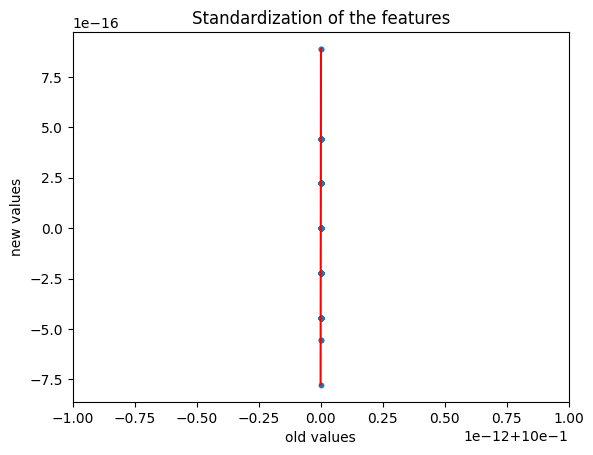

[0.00000000e+00 2.22044605e-16 2.22044605e-16 ... 2.22044605e-16
 0.00000000e+00 0.00000000e+00]
0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
5307    1.0
5308    1.0
5309    1.0
5310    1.0
5311    1.0
Name: 2, Length: 5272, dtype: float64
2.272250841370531e-17
1.2299294884745767e-16
1.0
1.2507428934359069e-16


In [93]:
# Plot the old and new values of the features to see the effect of standardization
import matplotlib.pyplot as plt
plt.scatter(x=old_features.iloc[:, 0], y=features[:, 0], s=10)
plt.plot([min(old_features.iloc[:, 0]), max(old_features.iloc[:, 0])], [min(features[:, 0]), max(features[:, 0])], color='red')
plt.xlabel('old values')
plt.ylabel('new values')
plt.title('Standardization of the features')
plt.show()

print(features[:, 0])
print(old_features.iloc[:, 0])

import numpy as np
print(np.mean(features[:, 0]))
print(np.std(features[:, 0]))

print(np.mean(old_features.iloc[:, 0]))
print(np.std(old_features.iloc[:, 0]))



In [94]:
X_test

array([[ 0.00000000e+00,  3.59920848e-01, -4.64073268e-01, ...,
         1.77965290e-01,  1.30598701e+00,  0.00000000e+00],
       [ 0.00000000e+00, -6.26335046e-01,  3.15869496e-02, ...,
        -5.76615054e-01, -1.27585539e+00,  0.00000000e+00],
       [-2.22044605e-16, -4.86071073e-01,  2.12965391e-01, ...,
        -1.10365263e-01,  5.03368762e-02,  0.00000000e+00],
       ...,
       [ 2.22044605e-16,  5.38245743e-01, -7.38644391e-01, ...,
        -5.04626112e-01,  1.50703211e+00,  0.00000000e+00],
       [ 0.00000000e+00,  6.12474021e-01, -6.61599879e-01, ...,
        -1.01395486e+00, -4.57566547e-01,  0.00000000e+00],
       [ 0.00000000e+00,  1.01664006e+00, -6.92539532e-01, ...,
        -9.08124817e-01,  8.79207046e-01,  0.00000000e+00]])

In [95]:
print(features.shape)

(5272, 97)


In [96]:
"""
%pip install keras --upgrade -q
#%pip install --upgrade protobuf
%pip install --upgrade pandas -q
%pip install protobuf==3.20 -q
%pip install tensorflow -q
"""

'\n%pip install keras --upgrade -q\n#%pip install --upgrade protobuf\n%pip install --upgrade pandas -q\n%pip install protobuf==3.20 -q\n%pip install tensorflow -q\n'

In [104]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, LSTM, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import losses
from sklearn.model_selection import train_test_split
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD
from tensorflow.keras import layers, Model
from keras.layers import LeakyReLU

# Input shape: (71749, 97)

# CNN + FFNN
def build_modelx():
    model = Sequential()
    
    # Convolutional layers
    model.add(Conv1D(filters=X.shape[1]/16, kernel_size=5, activation='relu'))
    model.add(Conv1D(filters=X.shape[1]/32, kernel_size=10, activation='relu'))
    model.add(MaxPooling1D(10))
    model.add(Conv1D(filters=80, kernel_size=10, activation='relu'))
    
    model.add(Flatten())
    
    # Batch normalization
    model.add(BatchNormalization())
    
    # Fully connected layers
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(targets.shape[1], activation='relu'))
    return model

# FFN
def build_model(output_size):
    model = Sequential()
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(64, activation=LeakyReLU(alpha=0.1)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(32, activation=LeakyReLU(alpha=0.1)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(16, activation=LeakyReLU(alpha=0.1)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation=LeakyReLU(alpha=0.1)))
    return model

# GRU

def build_modelx():
    model = Sequential()
    model.add(layers.GRU(64, return_sequences=True, input_shape=(features.shape[1], 1)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(layers.GRU(32))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(16, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(16, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(targets.shape[1], activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(targets.shape[1], activation='relu'))
    model.summary()
    return model
    

# CNN + LSTM
def build_modelx():
    model = Sequential()
    model.add(Conv1D(64, 3, activation='relu', input_shape=(features.shape[1], 1)))
    model.add(MaxPooling1D(3))
    model.add(Conv1D(32, 3, activation='relu'))
    model.add(MaxPooling1D(3))
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(32))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(targets.shape[1], activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(targets.shape[1], activation='relu'))
    model.summary()
    return model

def build_modelx():
    model = Sequential()
    model.add(Dense(12, input_dim=X.shape[1]))
    model.add(Activation('relu'))
    return model

In [105]:
#Possibility of using a "multi gpu" estimator (but doesn't work quite well for me...), and other optimizers (the default Adam optimizer seems to be the better one, though)
'''
parallel_estimator = multi_gpu_model(model, gpus=2)
optimizer = tf.train.RMSPropOptimizer(0.001)
'''

# Building the model
model = build_model(output_size=targets.shape[1])

# Compiling the model with a custom initial learning rate for Adam optimizer
initial_learning_rate = 0.0001  # Custom initial learning rate
adam_optimizer = Adam(learning_rate=initial_learning_rate)


adam = tf.keras.optimizers.Adam(learning_rate=0.005, beta_1=0.9, beta_2=0.999, amsgrad=True)
SGD = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
#model.compile(optimizer = SGD, loss = "categorical_crossentropy", metrics=['accuracy'])
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])


# Learning rate scheduler function
def lr_scheduler(epoch, lr):
    if epoch % 100 == 0 and epoch:
        return lr * 0.8
    return lr

from tensorflow.keras.callbacks import LearningRateScheduler
# Learning rate scheduler callback
lr_schedule = LearningRateScheduler(lr_scheduler)

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=100)

#display training progress for each completed epoch.
class PrintDot(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs):
    if epoch % 10 == 0: print('')
    print('.', end='')


# Check if GPU is available
if tf.test.is_gpu_available():
    print("GPU is available")
else:
    print("GPU is NOT available")

# Force TensorFlow to use GPU if available
if tf.test.is_gpu_available():
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.compat.v1.Session(config=config)
    tf.compat.v1.keras.backend.set_session(session)
    

couples = False
if couples:
    # predict only lambda1 and mu1, then lambda2 and mu2, then lambda3 and mu3, then q12, q13, q21, q23, q31, q32
    Y1 = Y[['lambda1_rescaled', 'mu1_rescaled']]
    Y2 = Y[['lambda2_rescaled', 'mu2_rescaled']]
    Y3 = Y[['lambda3_rescaled', 'mu3_rescaled']]
    Y4 = Y[['q12_rescaled', 'q13_rescaled', 'q21_rescaled', 'q23_rescaled', 'q31_rescaled', 'q32_rescaled']]
    
    Y1_test = Y_test[['lambda1_rescaled', 'mu1_rescaled']]
    Y2_test = Y_test[['lambda2_rescaled', 'mu2_rescaled']]
    Y3_test = Y_test[['lambda3_rescaled', 'mu3_rescaled']]
    Y4_test = Y_test[['q12_rescaled', 'q13_rescaled', 'q21_rescaled', 'q23_rescaled', 'q31_rescaled', 'q32_rescaled']]
    
    model1 = build_model(2)
    model2 = build_model(2)
    model3 = build_model(2)
    model4 = build_model(6)
    
    model1.compile(optimizer='adam', loss='mean_absolute_percentage_error', metrics=['accuracy'])
    model2.compile(optimizer='adam', loss='mean_absolute_percentage_error', metrics=['accuracy'])
    model3.compile(optimizer='adam', loss='mean_absolute_percentage_error', metrics=['accuracy'])
    model4.compile(optimizer='adam', loss='mean_absolute_percentage_error', metrics=['accuracy'])
    
    with tf.device('/GPU:0'):
        history1 = model1.fit(X, Y1, epochs=100, validation_split=valid_frac, batch_size=8000, callbacks=[early_stop, PrintDot()])
        history2 = model2.fit(X, Y2, epochs=100, validation_split=valid_frac, batch_size=8000, callbacks=[early_stop, PrintDot()])
        history3 = model3.fit(X, Y3, epochs=100, validation_split=valid_frac, batch_size=8000, callbacks=[early_stop, PrintDot()])
        history4 = model4.fit(X, Y4, epochs=100, validation_split=valid_frac, batch_size=8000, callbacks=[early_stop, PrintDot()])

else:

    # Training the model on GPU
    with tf.device('/GPU:0'):  # Specify GPU device
        history = model.fit(X, Y, epochs=10000, validation_split=valid_frac, batch_size=128, callbacks=[early_stop, PrintDot()])
    

GPU is available
Epoch 1/10000
33/33 [==============================] - 1s 12ms/step - loss: 0.9229 - accuracy: 0.1335 - val_loss: 0.2258 - val_accuracy: 0.1384
Epoch 2/10000
33/33 [==============================] - 0s 6ms/step - loss: 0.6413 - accuracy: 0.1508 - val_loss: 0.2326 - val_accuracy: 0.1355
Epoch 3/10000
33/33 [==============================] - 0s 7ms/step - loss: 0.5137 - accuracy: 0.1392 - val_loss: 0.2340 - val_accuracy: 0.1412
Epoch 4/10000
33/33 [==============================] - 0s 7ms/step - loss: 0.4308 - accuracy: 0.1368 - val_loss: 0.2369 - val_accuracy: 0.1545
Epoch 5/10000
33/33 [==============================] - 0s 6ms/step - loss: 0.3778 - accuracy: 0.1470 - val_loss: 0.2389 - val_accuracy: 0.1469
Epoch 6/10000
33/33 [==============================] - 0s 6ms/step - loss: 0.3446 - accuracy: 0.1465 - val_loss: 0.2377 - val_accuracy: 0.1526
Epoch 7/10000
33/33 [==============================] - 0s 7ms/step - loss: 0.3156 - accuracy: 0.1473 - val_loss: 0.2351 - va

In [106]:
if couples:
    # test the model on the test set
    lambda1_mu1 = model1.predict(X_test)
    lambda2_mu2 = model2.predict(X_test)
    lambda3_mu3 = model3.predict(X_test)
    q12_q13_q21_q23_q31_q32 = model4.predict(X_test)
    
    fig, ax = plt.subplots(2, 3, figsize=(15, 10))
    ax[0, 0].scatter(Y1_test['lambda1_rescaled'], lambda1_mu1[:, 0], s=1)
    ax[0, 0].plot([min(Y1_test['lambda1_rescaled']), max(Y1_test['lambda1_rescaled'])], [min(Y1_test['lambda1_rescaled']), max(Y1_test['lambda1_rescaled'])], color='red')
    ax[0, 0].set_xlabel('lambda1')
    ax[0, 0].set_ylabel('lambda1_pred')
    ax[0, 0].set_title('Prediction of lambda1')
    
    ax[0, 1].scatter(Y1_test['mu1_rescaled'], lambda1_mu1[:, 1], s=1)
    ax[0, 1].plot([min(Y1_test['mu1_rescaled']), max(Y1_test['mu1_rescaled'])], [min(Y1_test['mu1_rescaled']), max(Y1_test['mu1_rescaled'])], color='red')
    ax[0, 1].set_xlabel('mu1')
    ax[0, 1].set_ylabel('mu1_pred')
    ax[0, 1].set_title('Prediction of mu1')
    
    ax[0, 2].scatter(Y2_test['lambda2_rescaled'], lambda2_mu2[:, 0], s=1)
    ax[0, 2].plot([min(Y2_test['lambda2_rescaled']), max(Y2_test['lambda2_rescaled'])], [min(Y2_test['lambda2_rescaled']), max(Y2_test['lambda2_rescaled'])], color='red')
    ax[0, 2].set_xlabel('lambda2')
    ax[0, 2].set_ylabel('lambda2_pred')
    
    ax[1, 0].scatter(Y2_test['mu2_rescaled'], lambda2_mu2[:, 1], s=1)
    ax[1, 0].plot([min(Y2_test['mu2_rescaled']), max(Y2_test['mu2_rescaled'])], [min(Y2_test['mu2_rescaled']), max(Y2_test['mu2_rescaled'])], color='red')
    ax[1, 0].set_xlabel('mu2')
    ax[1, 0].set_ylabel('mu2_pred')
    
    ax[1, 1].scatter(Y3_test['lambda3_rescaled'], lambda3_mu3[:, 0], s=1)
    ax[1, 1].plot([min(Y3_test['lambda3_rescaled']), max(Y3_test['lambda3_rescaled'])], [min(Y3_test['lambda3_rescaled']), max(Y3_test['lambda3_rescaled'])], color='red')
    ax[1, 1].set_xlabel('lambda3')
    ax[1, 1].set_ylabel('lambda3_pred')
    
    ax[1, 2].scatter(Y3_test['mu3_rescaled'], lambda3_mu3[:, 1], s=1)
    ax[1, 2].plot([min(Y3_test['mu3_rescaled']), max(Y3_test['mu3_rescaled'])], [min(Y3_test['mu3_rescaled']), max(Y3_test['mu3_rescaled'])], color='red')
    ax[1, 2].set_xlabel('mu3')
    ax[1, 2].set_ylabel('mu3_pred')
    
    fig, ax = plt.subplots(2, 3, figsize=(15, 10))
    ax[0, 0].scatter(Y4_test['q12_rescaled'], q12_q13_q21_q23_q31_q32[:, 0], s=1)
    ax[0, 0].plot([min(Y4_test['q12_rescaled']), max(Y4_test['q12_rescaled'])], [min(Y4_test['q12_rescaled']), max(Y4_test['q12_rescaled'])], color='red')
    ax[0, 0].set_xlabel('q12')
    ax[0, 0].set_ylabel('q12_pred')
    ax[0, 0].set_title('Prediction of q12')
    
    ax[0, 1].scatter(Y4_test['q13_rescaled'], q12_q13_q21_q23_q31_q32[:, 1], s=1)
    ax[0, 1].plot([min(Y4_test['q13_rescaled']), max(Y4_test['q13_rescaled'])], [min(Y4_test['q13_rescaled']), max(Y4_test['q13_rescaled'])], color='red')
    ax[0, 1].set_xlabel('q13')
    ax[0, 1].set_ylabel('q13_pred')
    ax[0, 1].set_title('Prediction of q13')
    
    ax[0, 2].scatter(Y4_test['q21_rescaled'], q12_q13_q21_q23_q31_q32[:, 2], s=1)
    ax[0, 2].plot([min(Y4_test['q21_rescaled']), max(Y4_test['q21_rescaled'])], [min(Y4_test['q21_rescaled']), max(Y4_test['q21_rescaled'])], color='red')
    ax[0, 2].set_xlabel('q21')
    ax[0, 2].set_ylabel('q21_pred')
    ax[0, 2].set_title('Prediction of q21')
    
    ax[1, 0].scatter(Y4_test['q23_rescaled'], q12_q13_q21_q23_q31_q32[:, 3], s=1)
    ax[1, 0].plot([min(Y4_test['q23_rescaled']), max(Y4_test['q23_rescaled'])], [min(Y4_test['q23_rescaled']), max(Y4_test['q23_rescaled'])], color='red')
    ax[1, 0].set_xlabel('q23')
    ax[1, 0].set_ylabel('q23_pred')
    ax[1, 0].set_title('Prediction of q23')
    
    ax[1, 1].scatter(Y4_test['q31_rescaled'], q12_q13_q21_q23_q31_q32[:, 4], s=1)
    ax[1, 1].plot([min(Y4_test['q31_rescaled']), max(Y4_test['q31_rescaled'])], [min(Y4_test['q31_rescaled']), max(Y4_test['q31_rescaled'])], color='red')
    ax[1, 1].set_xlabel('q31')
    ax[1, 1].set_ylabel('q31_pred')
    ax[1, 1].set_title('Prediction of q31')
    
    ax[1, 2].scatter(Y4_test['q32_rescaled'], q12_q13_q21_q23_q31_q32[:, 5], s=1)
    ax[1, 2].plot([min(Y4_test['q32_rescaled']), max(Y4_test['q32_rescaled'])], [min(Y4_test['q32_rescaled']), max(Y4_test['q32_rescaled'])], color='red')
    ax[1, 2].set_xlabel('q32')
    ax[1, 2].set_ylabel('q32_pred')
    ax[1, 2].set_title('Prediction of q32')
    
            
    
    
    

In [107]:
#expname = '51k_lambda_mu'

# Save the model
model.save(chemin + '/model_' + expname + '.h5')

In [135]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, LSTM, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import losses
from sklearn.model_selection import train_test_split
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD
from tensorflow.keras import layers, Model
import numpy as np

# Define your features and targets
# Assuming 'features' and 'targets' are your input data and labels respectively

# Define the initial temperature, final temperature, and cooling rate
initial_temperature = 1.0
final_temperature = 0.01
cooling_rate = 0.99

# Define the number of iterations for SA
num_iterations = 1000

hist = []

def build_modelx(output_size):
    model = Sequential()
    model.add(Dense(output_size, activation=LeakyReLU(alpha=0.1)))
    return model

# Define the initial model
current_model = build_modelx(output_size=targets.shape[1])
current_model.compile(optimizer='adam', loss='mean_squared_error')  # Modify optimizer and loss function as needed
current_model.build(features.shape)  # Build the model with the input shape
current_loss = float('inf')  # Initialize with a high loss

# Loop over SA iterations
for i in range(num_iterations):
    # Perturb the current model parameters (weights and biases)
    perturbed_model = build_modelx(output_size=targets.shape[1])  # Create a new model with the same architecture
    perturbed_model.build(features.shape)  # Build the model with the input shape
    perturbed_model.set_weights(current_model.get_weights())  # Copy the weights and biases from the current model

    # Randomly perturb the weights and biases
    for layer in perturbed_model.layers:
        if hasattr(layer, 'kernel'):
            noise = np.random.normal(loc=0.0, scale=0.1, size=layer.kernel.shape)
            perturbed_model.set_weights([layer.kernel + noise, layer.bias])
            
        if hasattr(layer, 'bias'):
            noise = np.random.normal(loc=0.0, scale=0.1, size=layer.bias.shape)
            perturbed_model.set_weights([layer.kernel, layer.bias + noise])
            

    # Compile and evaluate the perturbed model
    perturbed_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])  # Modify optimizer and loss function as needed
    hist.append(perturbed_model.fit(features, targets, epochs=100, validation_split=valid_frac, batch_size=128, callbacks=[early_stop, PrintDot()]))
    perturbed_loss = perturbed_model.evaluate(features, targets)

    # Acceptance criterion based on the SA algorithm
    temperature = initial_temperature * (final_temperature / initial_temperature) ** (i / num_iterations)
    if temperature <= final_temperature:
        if perturbed_loss < current_loss:
            current_model = perturbed_model
            current_loss = perturbed_loss
        break
    if perturbed_loss < current_loss or (np.random.uniform(0, 1) < np.exp((current_loss - perturbed_loss) / temperature) and temperature > final_temperature):
        current_model = perturbed_model
        current_loss = perturbed_loss

# Once SA iterations are complete, 'current_model' will contain the best model found
current_model.summary()

Epoch 1/100
33/33 [==============================] - 0s 7ms/step - loss: 0.6056 - val_loss: 0.4357
Epoch 2/100
33/33 [==============================] - 0s 5ms/step - loss: 0.3363 - val_loss: 0.3244
Epoch 3/100
33/33 [==============================] - 0s 4ms/step - loss: 0.2815 - val_loss: 0.2822
Epoch 4/100
33/33 [==============================] - 0s 3ms/step - loss: 0.2536 - val_loss: 0.2552
Epoch 5/100
33/33 [==============================] - 0s 4ms/step - loss: 0.2337 - val_loss: 0.2354
Epoch 6/100
33/33 [==============================] - 0s 4ms/step - loss: 0.2193 - val_loss: 0.2208
Epoch 7/100
33/33 [==============================] - 0s 3ms/step - loss: 0.2078 - val_loss: 0.2089
Epoch 8/100
33/33 [==============================] - 0s 3ms/step - loss: 0.1969 - val_loss: 0.1979
Epoch 9/100
33/33 [==============================] - 0s 3ms/step - loss: 0.1879 - val_loss: 0.1880
Epoch 10/100
33/33 [==============================] - 0s 3ms/step - loss: 0.1790 - val_loss: 0.1794
Epoch 11/

In [109]:
# Now do the same with targets2

if model_name == "musse" and len(targets.columns) <= 6:
    # Building the model
    model2 = build_model()

    with tf.device('/GPU:0'):  # Specify GPU device
        history2 = model2.fit(X, Y2, epochs=250, validation_split=valid_frac, batch_size=2048, callbacks=[early_stop, PrintDot(), lr_schedule])

In [110]:
if model_name == "musse" and len(targets.columns) <= 6:
    # Save the model
    expname = '51k_q'
    model2.save(chemin + '/model2_' + expname + '.h5')

In [111]:
"""import keras
from keras import layers


def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Flatten())
    model.add(
        layers.Dense(
            # Tune number of units.
            units=hp.Int("units", min_value=32, max_value=512, step=32),
            # Tune the activation function to use.
            activation=hp.Choice("activation", ["relu", "tanh"]),
        )
    )
    # Tune whether to use dropout.
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.25))
    model.add(layers.Dense(12, activation="softmax"))
    # Define the optimizer learning rate as a hyperparameter.
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="mse",
        metrics=["mse"],
    )
    return model


import keras_tuner

model = build_model(keras_tuner.HyperParameters())


#Possibility of using a "multi gpu" estimator (but doesn't work quite well for me...), and other optimizers (the default Adam optimizer seems to be the better one, though)
'''
parallel_estimator = multi_gpu_model(model, gpus=2)
optimizer = tf.train.RMSPropOptimizer(0.001)
'''

# Building the model
model = build_model(keras_tuner.HyperParameters())

tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_loss",
    max_trials=3,
    executions_per_trial=2,
    overwrite=True,
    directory="my_dir",
    project_name="helloworld",
)

tuner.search_space_summary()

tuner.search(X, Y, epochs=5, validation_split=0.2)

# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
best_model.summary()

tuner.results_summary()"""

'import keras\nfrom keras import layers\n\n\ndef build_model(hp):\n    model = keras.Sequential()\n    model.add(layers.Flatten())\n    model.add(\n        layers.Dense(\n            # Tune number of units.\n            units=hp.Int("units", min_value=32, max_value=512, step=32),\n            # Tune the activation function to use.\n            activation=hp.Choice("activation", ["relu", "tanh"]),\n        )\n    )\n    # Tune whether to use dropout.\n    if hp.Boolean("dropout"):\n        model.add(layers.Dropout(rate=0.25))\n    model.add(layers.Dense(12, activation="softmax"))\n    # Define the optimizer learning rate as a hyperparameter.\n    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")\n    model.compile(\n        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),\n        loss="mse",\n        metrics=["mse"],\n    )\n    return model\n\n\nimport keras_tuner\n\nmodel = build_model(keras_tuner.HyperParameters())\n\n\n#Possibility of using

In [112]:
"""tuner.results_summary()

# Get the top 2 hyperparameters.
best_hps = tuner.get_best_hyperparameters(5)
# Build the model with the best hp.
model = build_model(best_hps[0])
# Fit with the entire dataset.
model.fit(X, Y, epochs=100, validation_split=0.2)"""

'tuner.results_summary()\n\n# Get the top 2 hyperparameters.\nbest_hps = tuner.get_best_hyperparameters(5)\n# Build the model with the best hp.\nmodel = build_model(best_hps[0])\n# Fit with the entire dataset.\nmodel.fit(X, Y, epochs=100, validation_split=0.2)'

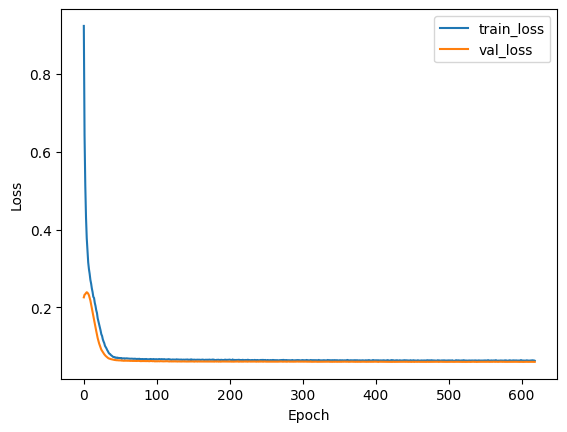

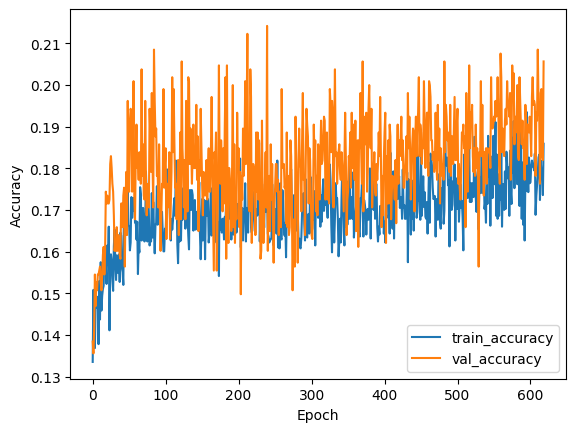

"\nplt.plot(history.history['mean_absolute_percentage_error'], label='train_MAPE')\nplt.plot(history.history['val_mean_absolute_percentage_error'], label='val_MAPE')\nplt.xlabel('Epoch')\nplt.ylabel('MAPE')\nplt.legend()\nplt.show()\n"

In [113]:
import matplotlib.pyplot as plt
# Plot training history
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plot accuracy
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

"""
plt.plot(history.history['mean_absolute_percentage_error'], label='train_MAPE')
plt.plot(history.history['val_mean_absolute_percentage_error'], label='val_MAPE')
plt.xlabel('Epoch')
plt.ylabel('MAPE')
plt.legend()
plt.show()
"""


In [114]:
# Make predictions on the test dataset
predictions = model.predict(X_test)
#predictions2 = model2.predict(X_test)

42/42 [==============================] - 0s 2ms/step


[[0.39606905 0.39007127 0.3834054  ... 0.26004833 0.39458883 0.39658126]
 [0.44278863 0.44111106 0.45208985 ... 0.37479076 0.45519462 0.4425456 ]
 [0.42480406 0.42098504 0.42307952 ... 0.32813668 0.42874718 0.42256844]
 ...
 [0.38589457 0.38071528 0.36636257 ... 0.23498075 0.3804391  0.3841523 ]
 [0.383565   0.378769   0.3638304  ... 0.2304913  0.3786596  0.38272735]
 [0.37479058 0.3704646  0.34173167 ... 0.20328784 0.3594097  0.3647858 ]]
5312    0.596988
5313    0.559939
5314    0.455812
5315    0.367189
5316    0.514197
          ...   
6644    0.454557
6645    0.351638
6646    0.305925
6648    0.467366
6649    0.126199
Name: sA_rescaled, Length: 1318, dtype: float64
1.1090915
2.1484964480344426


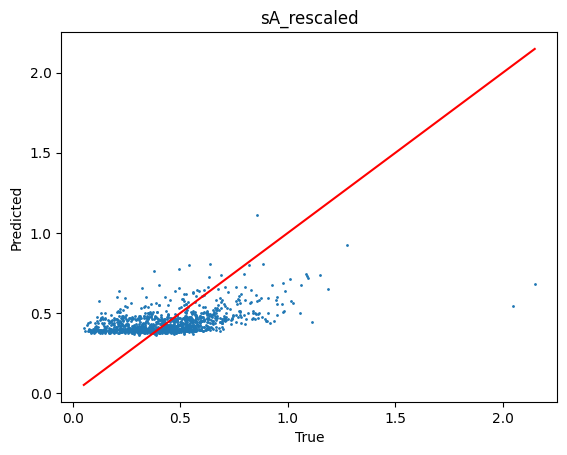

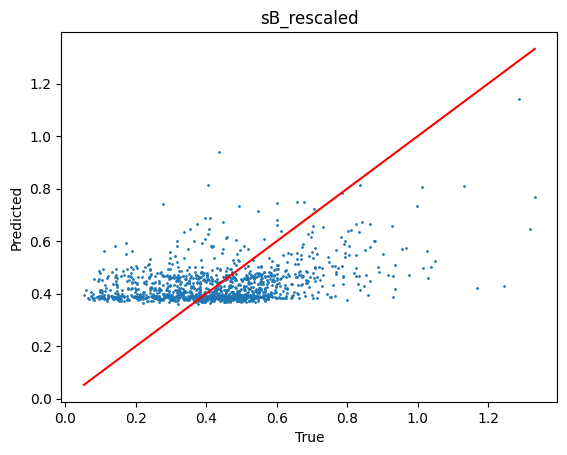

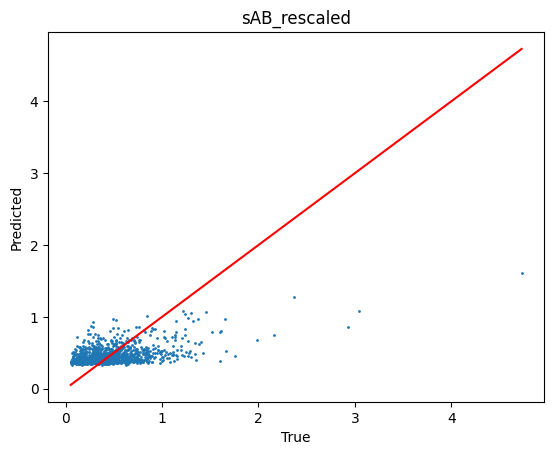

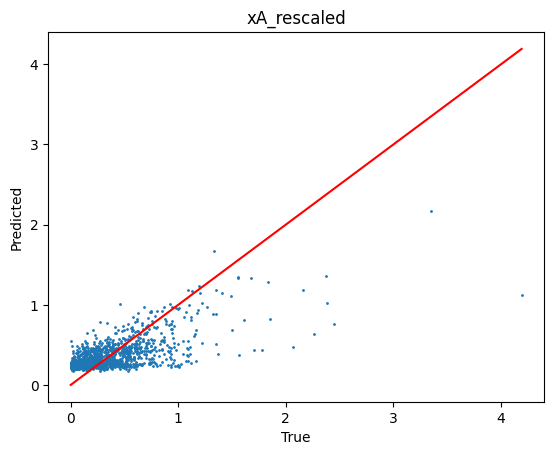

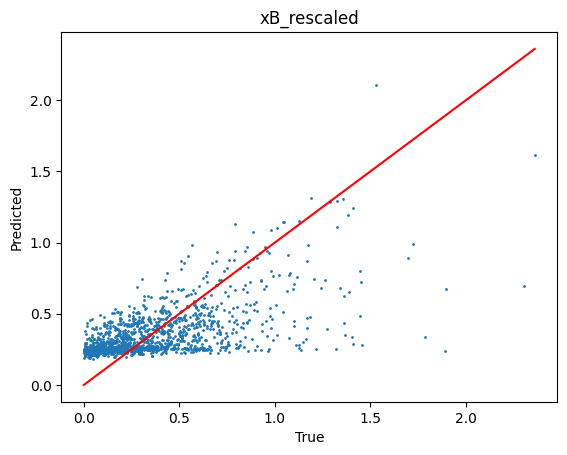

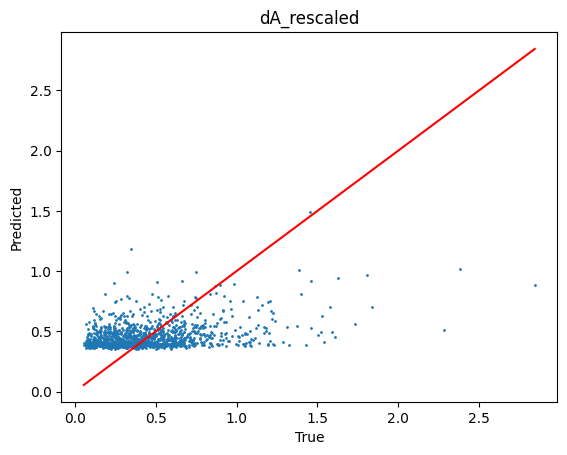

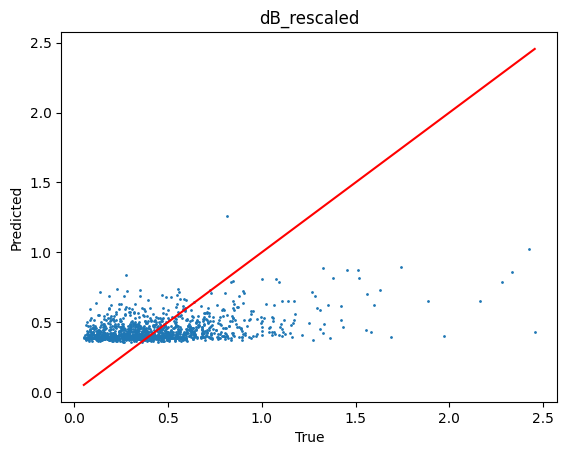

In [115]:
import matplotlib.pyplot as plt

print(predictions)
print(Y_test.iloc[:, 0])

print(max(predictions[:, 0]))
print(max(Y_test.iloc[:, 0]))

# plot predictions vs true values for each parameter in the training set
for i in range(predictions.shape[1]):
    plt.scatter(Y_test.iloc[:, i], predictions[:, i], s=1)
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.title(Y_test.columns[i])
    # add a diagonal line
    plt.plot([Y_test.iloc[:, i].min(), Y_test.iloc[:, i].max()], [Y_test.iloc[:, i].min(), Y_test.iloc[:, i].max()], color='red')
    plt.show()


165/165 [==============================] - 0s 2ms/step


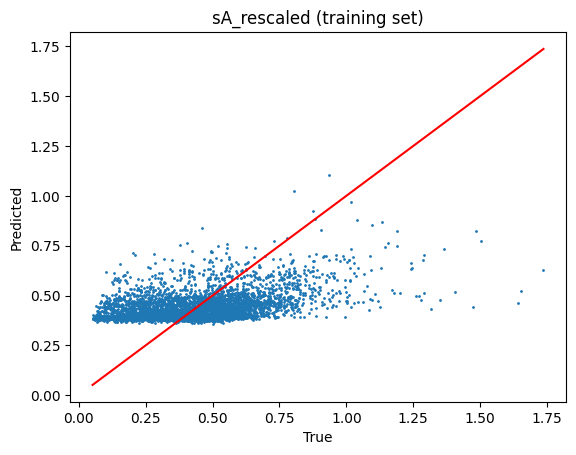

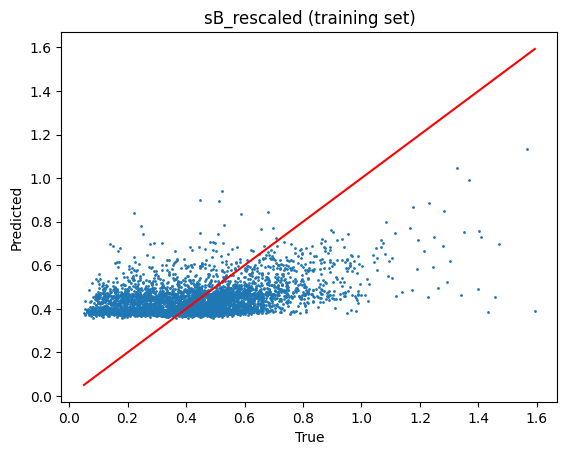

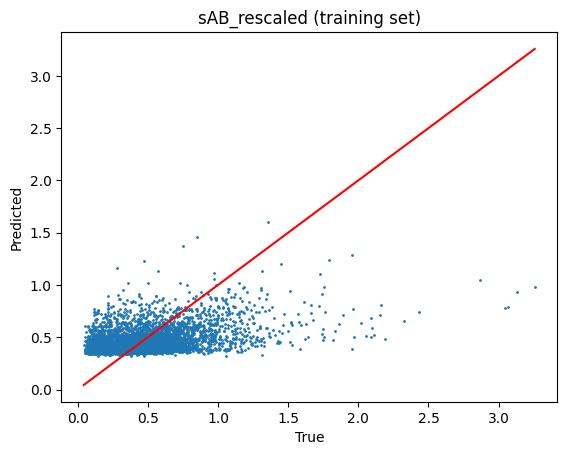

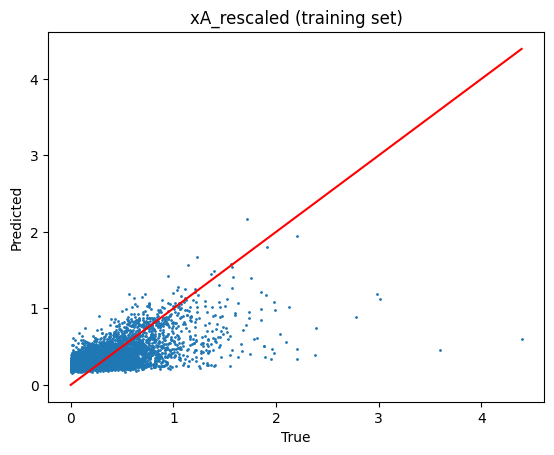

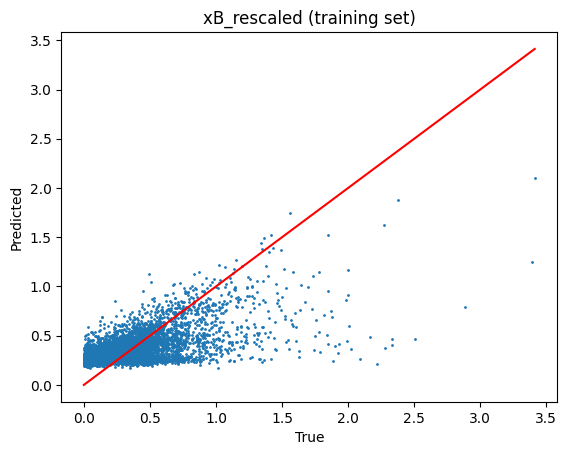

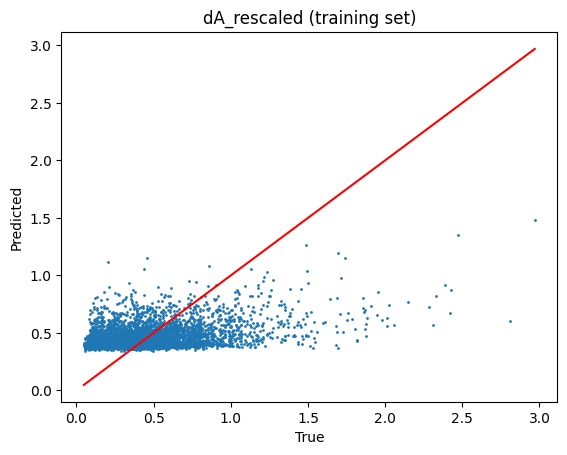

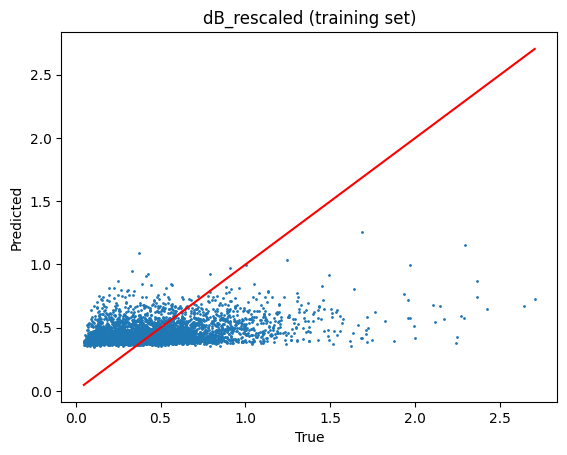

In [116]:
# Predict the training set
predictions_train = model.predict(X)
#predictions_train2 = model2.predict(X)

# plot predictions vs true values for each parameter in the training set
for i in range(predictions_train.shape[1]):
    plt.scatter(Y.iloc[:, i], predictions_train[:, i], s=1)
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.title(Y.columns[i] + ' (training set)')
    # add a diagonal line
    plt.plot([Y.iloc[:, i].min(), Y.iloc[:, i].max()], [Y.iloc[:, i].min(), Y.iloc[:, i].max()], color='red')
    plt.show()

In [ ]:
if model_name == "musse" and len(targets.columns) <= 6:
    for i in range(predictions2.shape[1]):
        plt.scatter(Y_test2.iloc[:, i], predictions2[:, i], s=1)
        plt.xlabel('True')
        plt.ylabel('Predicted')
        plt.title(Y_test2.columns[i])
        # add a diagonal line
        plt.plot([Y_test2.iloc[:, i].min(), Y_test2.iloc[:, i].max()], [Y_test2.iloc[:, i].min(), Y_test2.iloc[:, i].max()], color='red')
        plt.show()
        plt.savefig(chemin + '/prediction2_' + Y_test2.columns[i] + '.png')

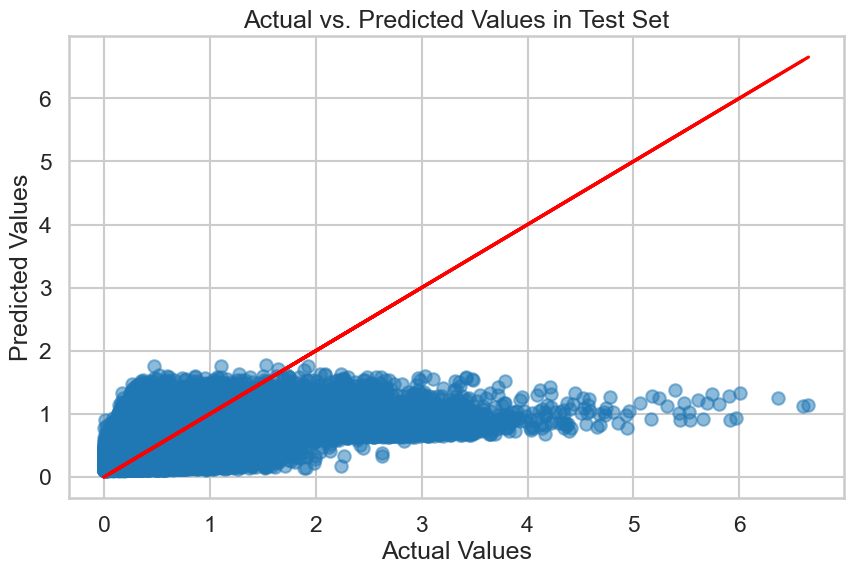

Mean Absolute Error (MAE):
 0.2929202343452109
Mean Absolute Percentage Error (MAPE):
 223.28542928972968


<Figure size 640x480 with 0 Axes>

In [ ]:
# Plot predictions vs. actuals
plt.figure(figsize=(10, 6))
# small size points
plt.scatter(Y_test, predictions, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values in Test Set')
# add perfect fit line
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], color='red')
plt.show()
plt.savefig(chemin + '/prediction_all.png')

# Calculate performance metrics
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(Y_test, predictions)
print("Mean Absolute Error (MAE):\n", mae)

# If your Y values are in a wide range, it's useful to normalize them before computing MAPE
mape = np.mean(np.abs((Y_test - predictions) / Y_test)) * 100
print("Mean Absolute Percentage Error (MAPE):\n", mape)

In [ ]:
# plot absolute errors with respect to the tree size, the file is trees directory + model + ".sizes", text lines
sizes = []
sizes = pd.read_csv(trees_directory + model_name + '.sizes', sep='\t', header=None)
print(sizes.shape)
sizes = sizes.drop(lines_to_remove)

    

# take only the sizes that correspond to the test set
sizes = sizes[cutoff:][0]
errors = np.abs(Y_test - predictions)

print(sizes.shape)
print(errors.shape)

# for each parameter, plot the absolute error vs. tree size
for i in range(targets.shape[1]):
    plt.scatter(sizes, errors.iloc[:, i], s=1)
    # add trend line
    z = np.polyfit(sizes, errors.iloc[:, i], 1)
    p = np.poly1d(z)
    plt.plot(sizes, p(sizes), "r--")
    # add 95% confidence interval
    plt.fill_between(sizes, p(sizes) - 1.96 * np.std(errors.iloc[:, i]), p(sizes) + 1.96 * np.std(errors.iloc[:, i]), color='r', alpha=0.2)
    plt.xlabel('Tree Size')
    plt.ylabel('Absolute Error')
    plt.title(targets.columns[i])
    # start from 0, set ylim to be the max value of the parameter
    maxval = Y_test.iloc[:, i].max()
    plt.ylim([0, maxval])
    plt.show()


In [ ]:
%pip install seaborn -q

Note: you may need to restart the kernel to use updated packages.


561/561 [==============================] - 2s 4ms/step


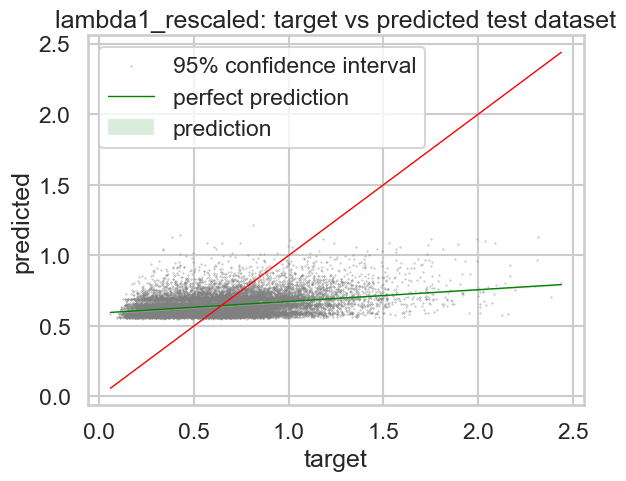

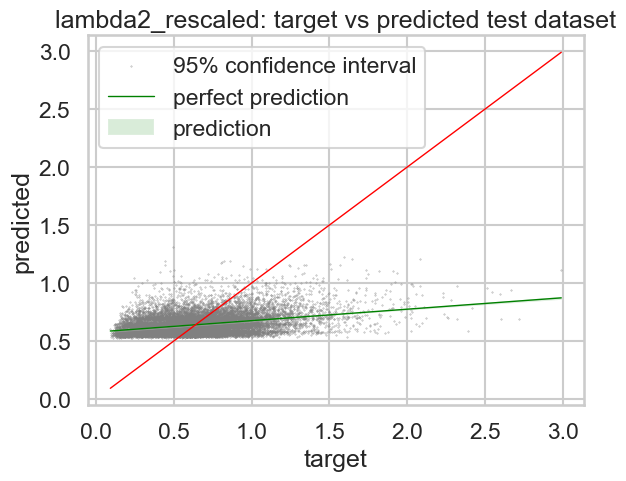

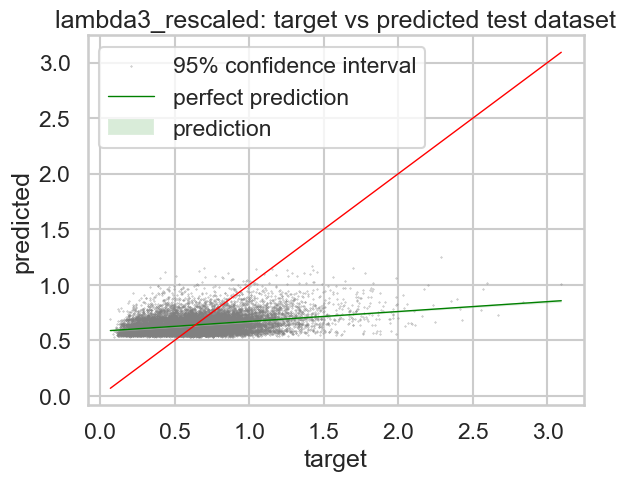

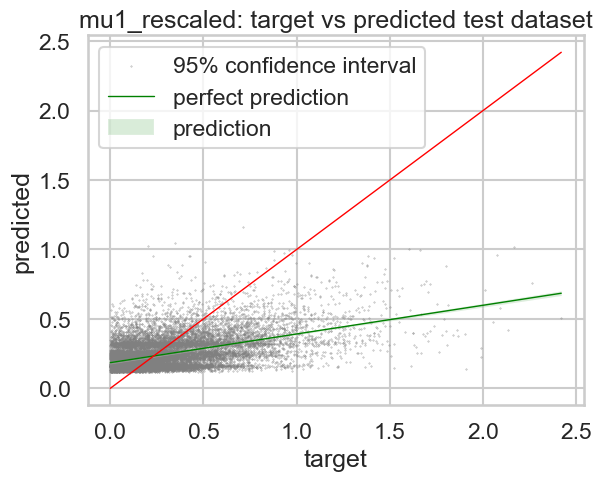

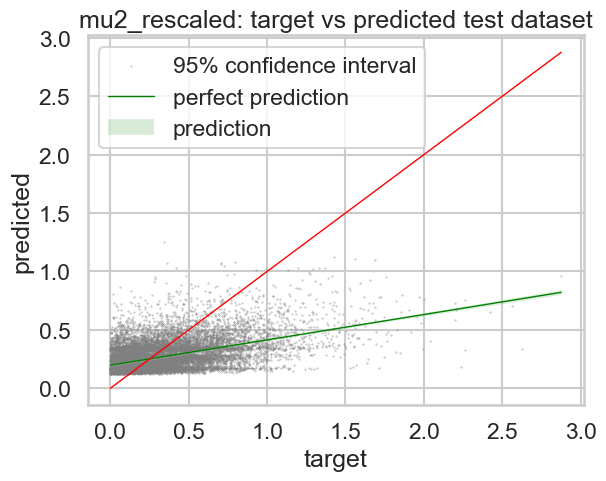

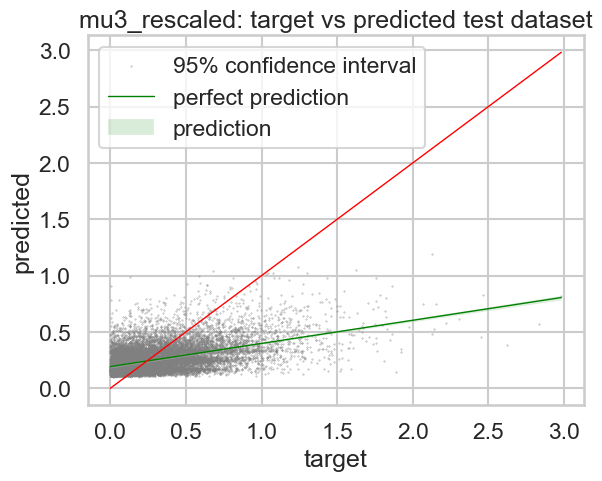

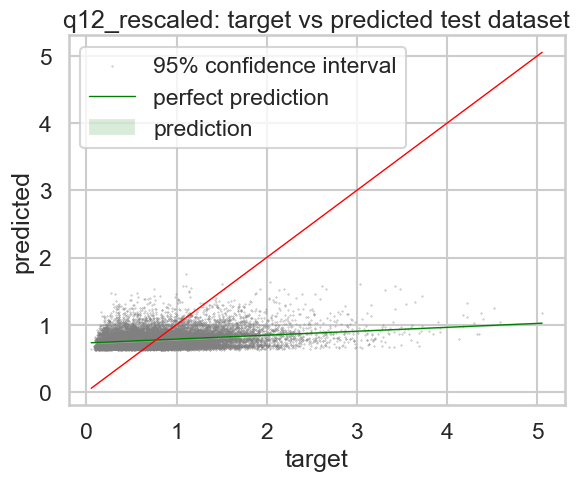

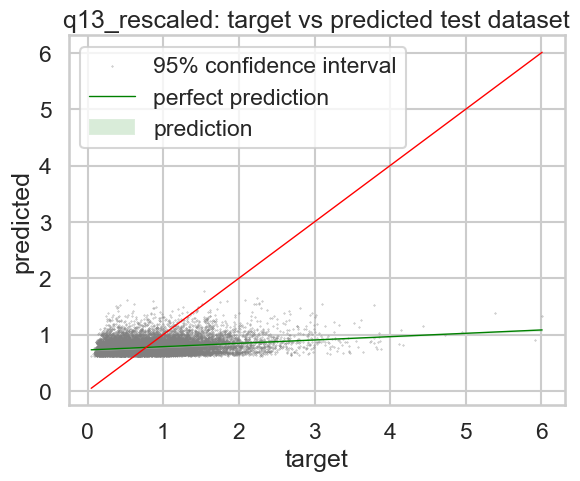

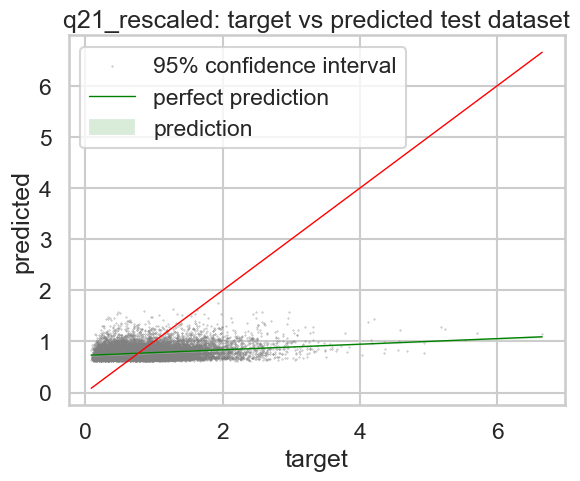

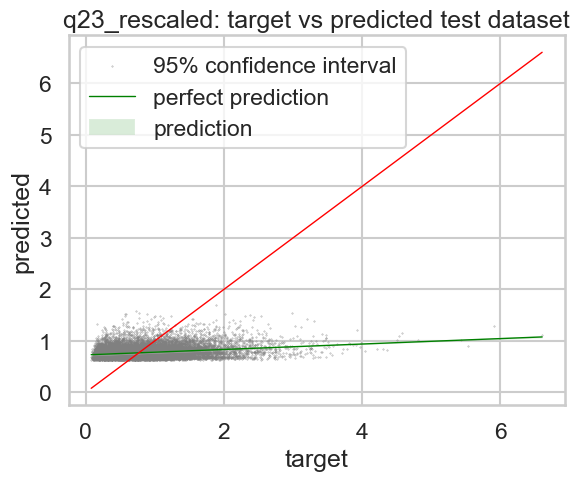

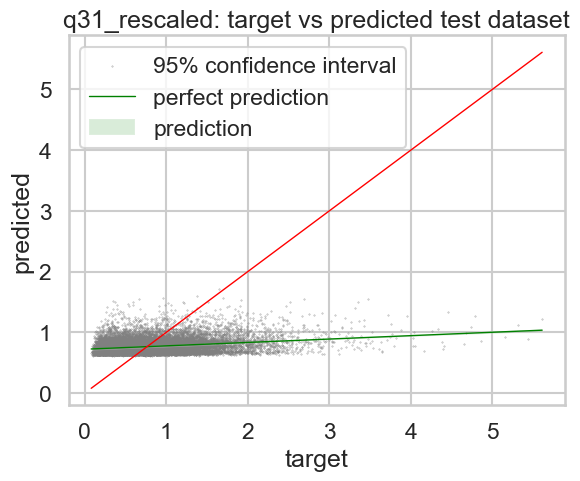

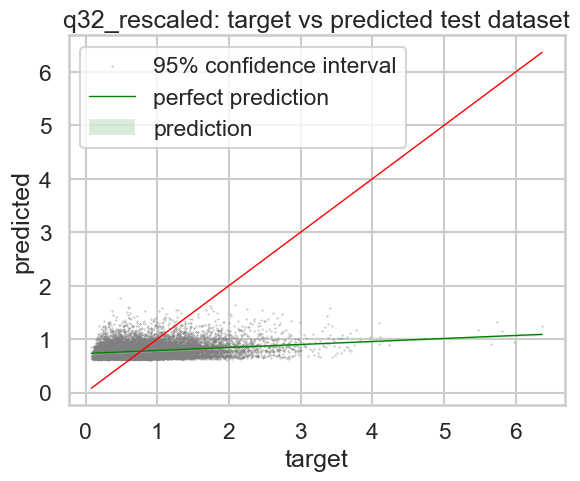

In [ ]:
#import statsmodel.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

#Plot test vs predicted
# predict values for the test set
predicted_test = pd.DataFrame(model.predict(X_test))
predicted_test.columns = Y_test.columns # rename correctly the columns
predicted_test.index = Y_test.index # rename indexes for correspondence

elts = []

# just for subsetting columns more automatically + naming output plots
for elt in Y_test.columns:
    elts.append(elt)

for elt in elts:
    sub_df = pd.DataFrame({'predicted_minus_target_' + elt: predicted_test[elt] - Y_test[elt], 'target_'+elt: Y_test[elt], 'predicted_'+elt: predicted_test[elt]})
    if elt == elts[0]:
        df = sub_df
    else:
        sub_df.index = df.index
        df = pd.concat([df, sub_df], axis=1)
    

# fast plotting for analysis (with seaborn):
def target_vs_predicted(target_name, predicted_name, param_name, file_name_beg) : 
    sns.set_style('whitegrid')
    sns.set_context('talk')
    sns.regplot(x=target_name, y=predicted_name, data=df, ci=95, n_boot=500, 
                scatter_kws={'s':0.1, 'color':'grey'}, line_kws={ 'color':'green', 'linewidth':1})
    plt.title(param_name + ': target vs predicted test dataset')
    plt.xlabel('target')
    plt.ylabel('predicted')
    innerlimit = min(df[target_name])
    outerlimit = max(df[target_name])
    plt.plot([innerlimit, outerlimit], [innerlimit, outerlimit], linewidth=1, color='red', label='perfect prediction')
    plt.legend(['95% confidence interval', 'perfect prediction', 'prediction'])
    
    plt.savefig(chemin + '/' + file_name_beg + '_target_vs_predicted.png')
    plt.show()
    return None

def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    


for elt in elts:
    target_vs_predicted('target_'+elt, 'predicted_'+elt, elt, file_name_beg=elt)


    
    

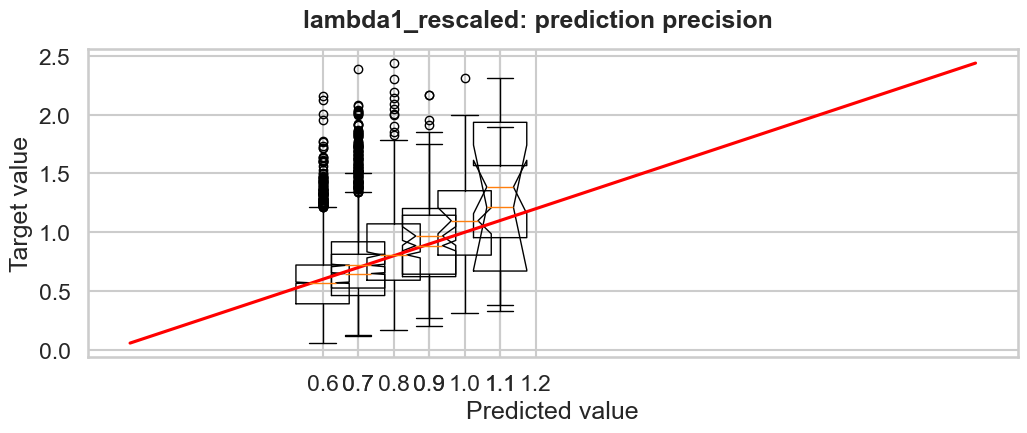

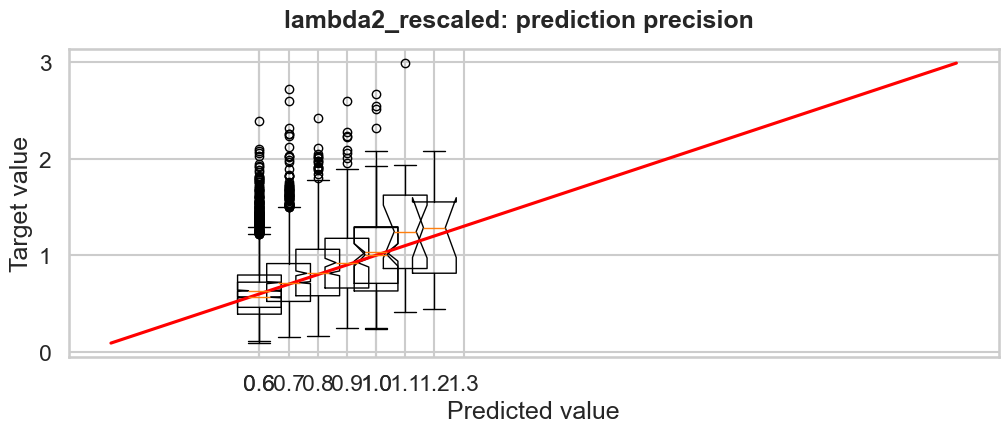

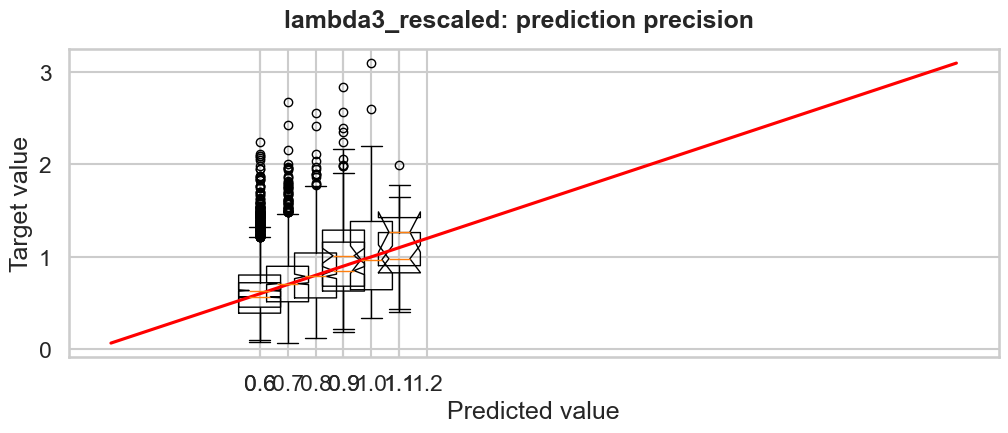

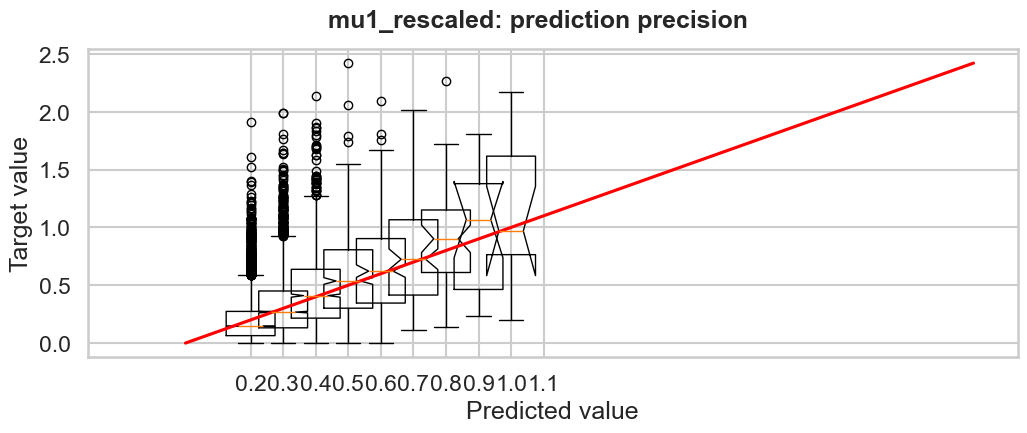

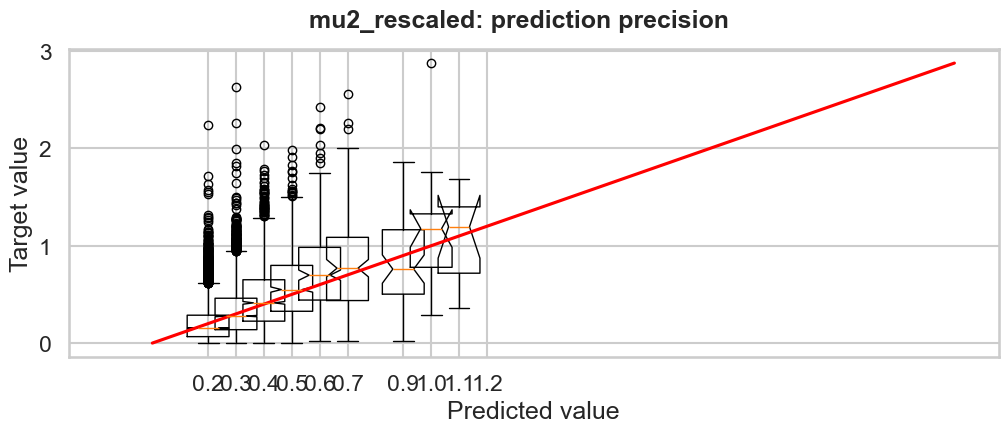

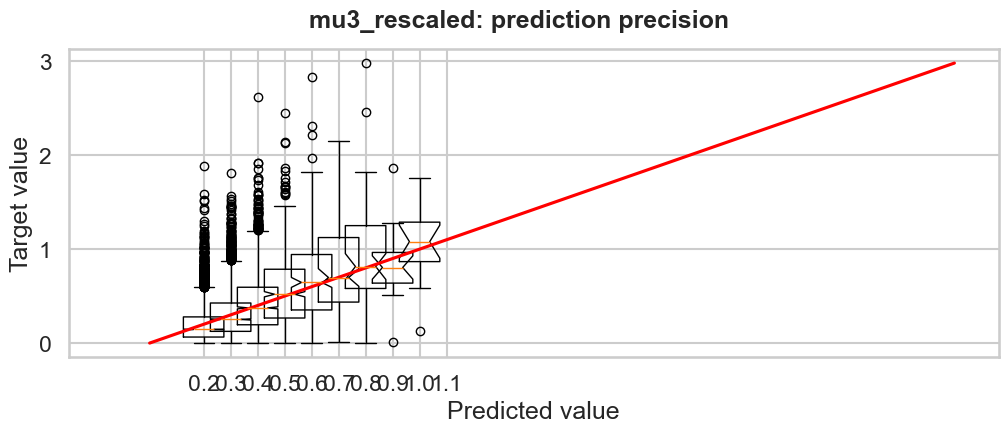

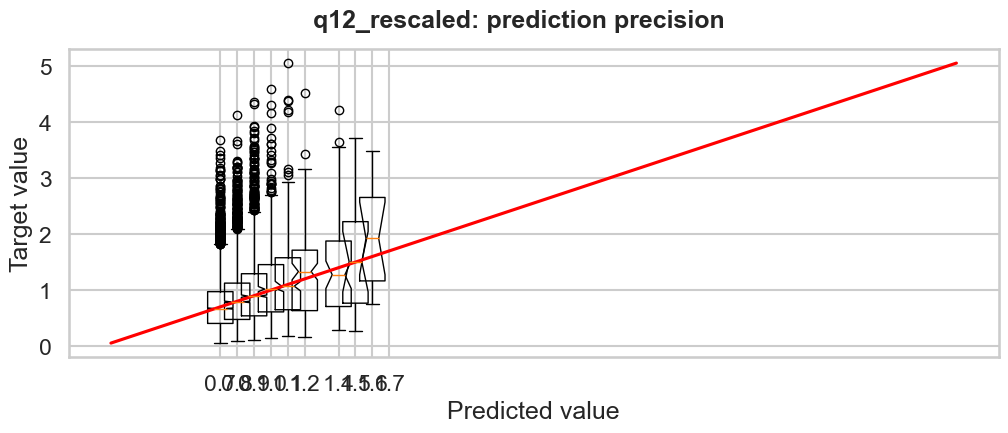

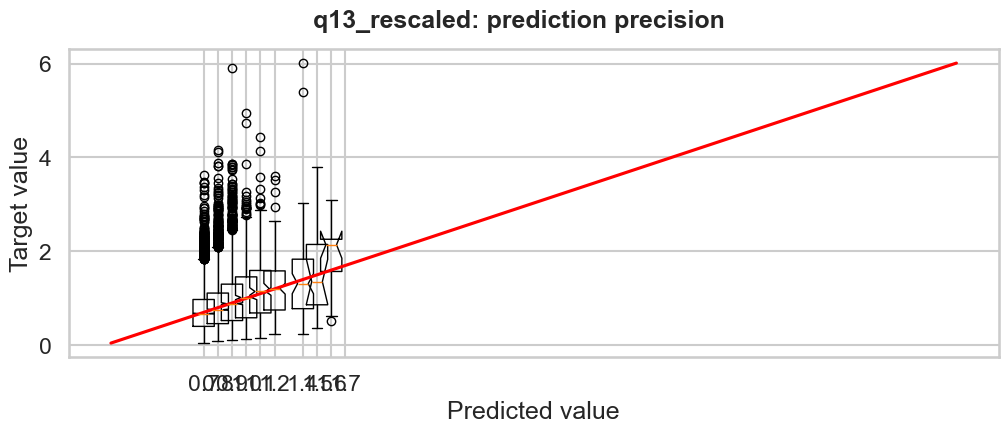

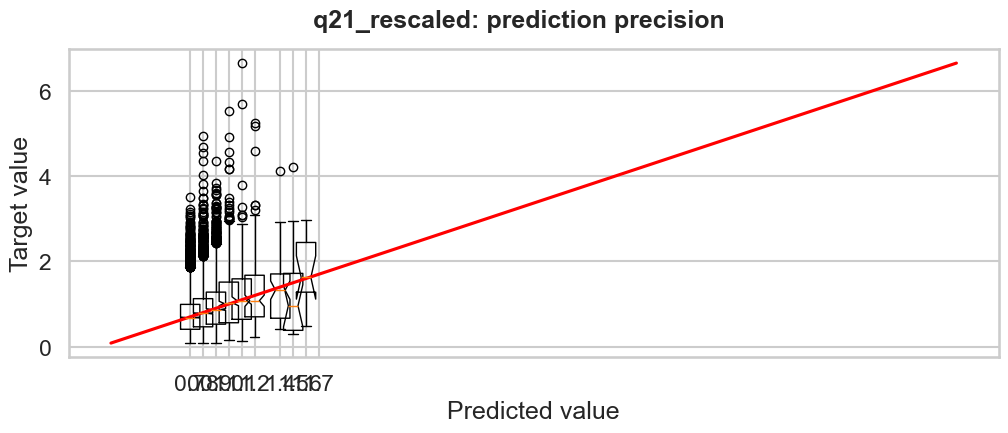

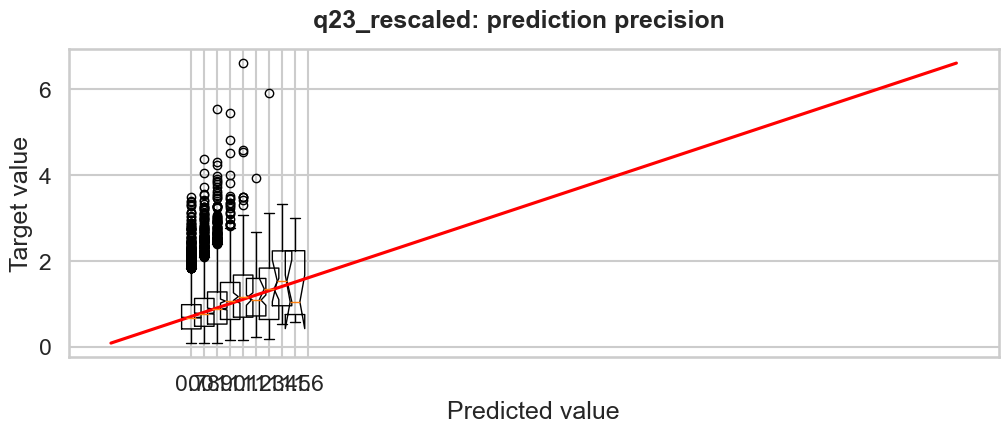

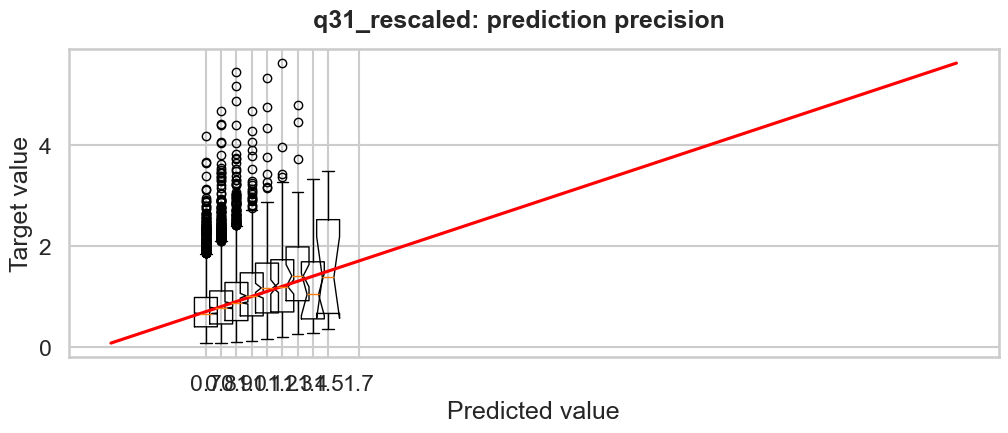

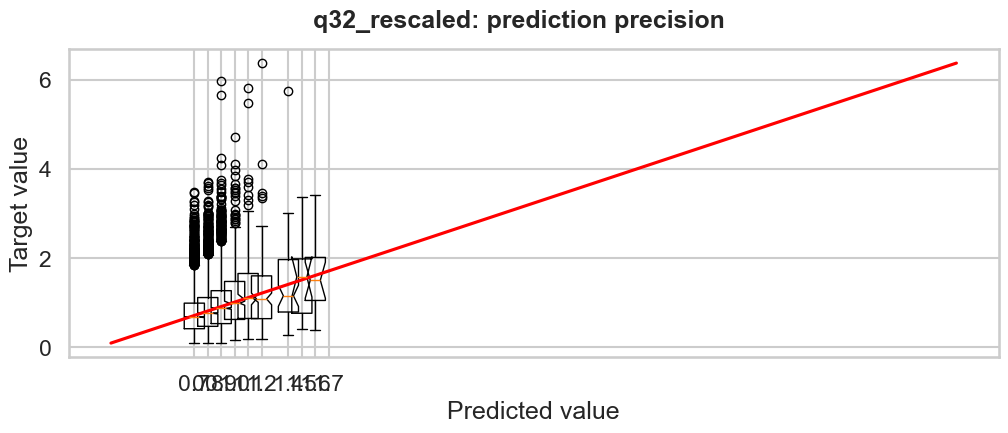

In [ ]:
###boxplots

from pylab import *

def sd_bins(name_target, name_predicted, nb_bins):
    b_indexes = np.digitize(df[name_predicted], bins=np.linspace(min(df[name_predicted]),max(df[name_predicted]),num=nb_bins))
    list_sd = []
    x_axis = []
    
    list_b = [[] for i in range(max(b_indexes)-1)]
    for i in range(1, nb_bins):
        list_b[i-1] = np.array(df[name_target][b_indexes == i])
        #print(df[name_target][b_indexes == i])
        #print(i)
        #print(len(df['predicted_minus_target_R_nought'][a_indexes == i]))
        if len(list_b[i-1]) > 1:
            list_sd.append(np.std(list_b[i-1]))
        else :
            list_sd.append([None])
    
    x_bins = np.linspace(min(df[name_predicted]), max(df[name_predicted]), num=nb_bins)
    
    for i in range(0,len(x_bins)-1):
        x_axis.append(float("{0:.1f}".format((x_bins[i]+x_bins[i+1])/2)))
        
    return list_b, list_sd, x_axis        

def plot_boxplot(name_target, name_predicted, nb_bin, maintitle, directory, file_name):
    min_val = min(df[name_target])
    
    max_val = max(df[name_target])
    
    arrays_target, array_sd, position_list = sd_bins(name_target, name_predicted, nb_bins=nb_bin)
    fig = plt.figure(figsize=(12,4))
    fig.suptitle(maintitle, fontsize=18, fontweight='bold')
    
    ax = fig.add_subplot(111)
    ax.boxplot(arrays_target, positions=position_list, notch=True)
    
    ax.set_xlabel('Predicted value')
    ax.set_ylabel('Target value')

    
    plt.plot(np.linspace(min_val, max_val, 5), np.linspace(min_val, max_val, 5), color='red')
    #plt.savefig('../Plots2/' + chemin + file_name + '.png')
    #plt.savefig('../Plots/' + directory + file_name + '.png')
    plt.show()
    return None
    
for elt in elts:
    plot_boxplot('target_'+elt, 'predicted_'+elt, 11, elt+': prediction precision', directory = chemin, file_name='boxplot_' + elt + '_pred_vs_target')

#plot_boxplot('target_sampling_proba','predicted_sampling_proba', 11 , 'Transmission rate: prediction precision', min_val=0, max_val=1, directory = chemin, file_name='boxplot_sampling_proba_pred_vs_target')


In [ ]:
# table with statistics on errors
errors_index = elts
errors_columns = ['MAE', 'RMSE', 'RME']
errors = pd.DataFrame(index=errors_index, columns=errors_columns)

def get_mae_rmse(name_var):
    predicted_vals = df['predicted_' + name_var]
    target_vals = df['target_' + name_var]
    diffs_abs = abs(target_vals - predicted_vals)
    diffs_rel = diffs_abs/target_vals
    diffs_abs_squared = diffs_abs**2
    mae = np.sum(diffs_abs)/len(diffs_abs)
    rmse = np.sqrt(sum(diffs_abs_squared)/len(diffs_abs_squared))
    rme = np.sum(diffs_rel)/len(diffs_rel)
    return mae, rmse, rme
    

#errors.loc['R_nought'] = np.array(get_mae_rmse('R_nought'))
for elt in errors_index:
    errors.loc[elt] = np.array(get_mae_rmse(elt))

print(errors)



# do the same with scaled values

# multiply the errors by the mean of the scaling factor
errors_scaled = errors.copy()
errors_scaled['MAE'] = errors['MAE']*param_test['norm_factor'].mean()
errors_scaled['RMSE'] = errors['RMSE']*param_test['norm_factor'].mean()
errors_scaled['RME'] = errors['RME']

                      MAE      RMSE       RME
lambda_rescaled  0.056909   0.08028    0.0853
mu_rescaled      0.083827  0.112448  2.041375


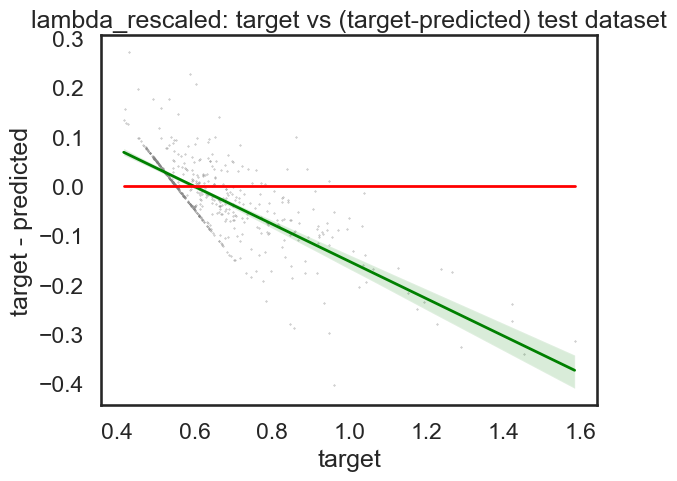

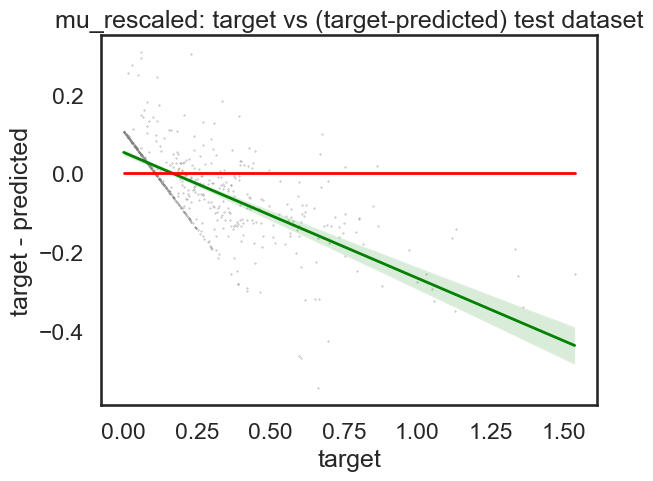

In [ ]:
#print differences between predicted and target as function of target: showing structural bias

def predicted_minus_target_vs_target(pr_m_tar_name, target_name, param_name, file_name_beg) : 
    sns.set_style('white')
    sns.set_context('talk')
    sns.regplot(x=target_name, y=pr_m_tar_name, data=df, ci=95, n_boot=500, 
                scatter_kws={'s':0.1, 'color':'grey'}, line_kws={ 'color':'green', 'linewidth':2})
    plt.title(param_name + ': target vs (target-predicted) test dataset')
    plt.xlabel('target')
    plt.ylabel('target - predicted')
    innerlimit = min(df[target_name])
    
    outerlimit = max(df[target_name])
    
    plt.plot([innerlimit, outerlimit], [0, 0], linewidth=2, color='red')
    plt.show()
    return None


for elt in elts:
    predicted_minus_target_vs_target('predicted_minus_target_'+elt, 'target_'+elt, elt, file_name_beg=elt)


In [ ]:
#measure of correlation: predicted vs target
from scipy.stats import spearmanr, pearsonr

from sklearn.metrics import r2_score

pearson_cors = []

for elt in elts:
    pearson_cors.append(pearsonr(Y_test[elt], predicted_test[elt])[0])

print("Global pearson correlation between predicted and effective parameter: ", Y_test.columns, pearson_cors)


Global pearson correlation between predicted and effective parameter:  Index(['lambda_rescaled', 'mu_rescaled'], dtype='object') [0.8849553556012479, 0.9021199087929893]


In [ ]:
###save the model, weights (and scaler for sumstats only)

from tensorflow.keras.models import model_from_json

# save model
model_trial_1000 = model.to_json()
with open(chemin + '/model_all' + expname + '.json','w') as json_file:
    json_file.write(model_trial_1000)

# save weights
model.save_weights(chemin + '/model_all_weights' + expname +'.h5')
print('model saved!')

'''
#load the model
json_file = open('../Model/' + chemin + 'model_all' + expname + '.json', 'r')
loaded_file = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_file)
#load weights
loaded_model.load_weights(../Model/' + chemin + 'model_all_weights' + expname +'.h5'5)
print('model loaded!')

'''

#save scaler when there is one (FFNN-SS)
"""
from sklearn.externals import joblib

scale_filename = '../../Model/' + chemin + 'all_standardscaler' + expname + '.pkl'
joblib.dump(scale, scale_filename)

print('scale saved!')
#load scaler:
#scale = joblib.load(scale_filename)
"""


model saved!


"\nfrom sklearn.externals import joblib\n\nscale_filename = '../../Model/' + chemin + 'all_standardscaler' + expname + '.pkl'\njoblib.dump(scale, scale_filename)\n\nprint('scale saved!')\n#load scaler:\n#scale = joblib.load(scale_filename)\n"

In [ ]:
####save the predicted and the target dataframes

Y_test.to_csv(chemin + expname + 'target_all.csv', header=True)

predicted_test.to_csv(chemin + expname + 'predicted_all.csv', header=True)

## Statistics and Visualization

In [ ]:
import pandas as pd
chemin = './trained_models/musse/'
expname='90k'

# Read the data
Y_test = pd.read_csv(chemin + expname + 'target_all.csv', index_col=0)
predicted_test = pd.read_csv(chemin + expname + 'predicted_all.csv', index_col=0)

In [ ]:
table = pd.concat([Y_test.iloc[0], predicted_test.iloc[0]], axis=1)
table['difference'] = table.iloc[:, 0] - table.iloc[:, 1]
table['difference'] = table['difference'].apply(lambda x: f"{x:.2f}")
# set column names
table.columns = ['target', 'predicted', 'difference']
table


,target,predicted,difference
lambda_rescaled,0.508806,0.625949,-0.12
mu_rescaled,0.202154,0.228801,-0.03


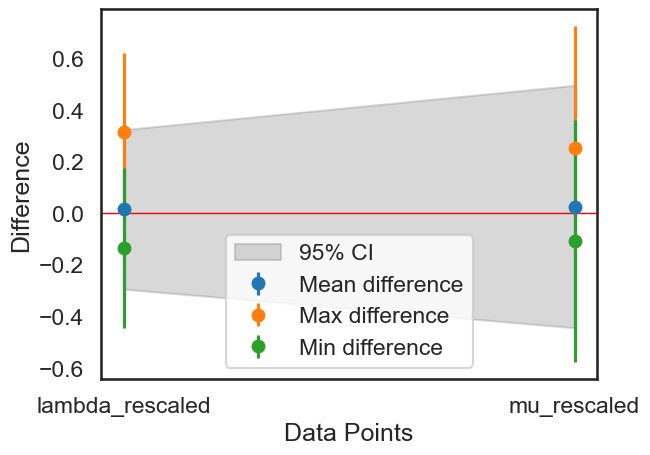

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming Y_test and predicted_test are already defined

table = pd.concat([Y_test.mean(), predicted_test.mean()], axis=1)
table['difference'] = table.iloc[:, 0] - table.iloc[:, 1]

# Calculate upper and lower bounds for 95% confidence interval
ci = 1.96 * Y_test.std()  # 1.96 is the z-value for 95% confidence interval in a standard normal distribution
upper_ci = table['difference'] + ci
lower_ci = table['difference'] - ci

# plot also points at max values and min values
max_vals = pd.concat([Y_test.max(), predicted_test.max()], axis=1)
max_vals['difference'] = max_vals.iloc[:, 0] - max_vals.iloc[:, 1]
min_vals = pd.concat([Y_test.min(), predicted_test.min()], axis=1)
min_vals['difference'] = min_vals.iloc[:, 0] - min_vals.iloc[:, 1]
plt.errorbar(table.index, table['difference'], yerr=ci, fmt='o', label='Mean difference')
plt.errorbar(max_vals.index, max_vals['difference'], yerr=ci, fmt='o', label='Max difference')
plt.errorbar(min_vals.index, min_vals['difference'], yerr=ci, fmt='o', label='Min difference')
plt.fill_between(table.index, lower_ci, upper_ci, color='grey', alpha=0.3, label='95% CI')

# Add horizontal line at y=0
plt.axhline(y=0, color='r', linestyle='-', linewidth=1)

# Add labels and legend
plt.xlabel('Data Points')
plt.ylabel('Difference')
plt.legend()

# Show plot
plt.show()


In [ ]:
# plot the absolute error with respect of the size of the tree
# compute the size of the tree
import numpy as np
import pandas as pd
import os
from ete3 import Tree

def get_tree_size(tree_file):
    with open(tree_file, 'r') as tree_file:
        forest = tree_file.read().replace("\n", "")
        trees = forest.split(";")
        sizes = []
        for i in range(0, len(trees)):
            print("\r" + "Processing tree " + str(i) + " of " + str(len(trees)))
            sys.stdout.flush()
            if len(trees[i]) > 0:
                tree = Tree(trees[i] + ";", format=1)
                size = len(tree.get_leaves())
                sizes.append(size)
        return sizes

# Load the tree files
trees_directory = "trees/"
tree_sizes = get_tree_size(trees_directory + model_name + ".nwk")

# Load the predicted and target values
Y_test = pd.read_csv(chemin + expname + 'target_all.csv', index_col=0)
predicted_test = pd.read_csv(chemin + expname + 'predicted_all.csv', index_col=0)

# Calculate the absolute error
absolute_error = abs(Y_test - predicted_test)

# Plot the absolute error with respect to the size of the tree
plt.scatter(tree_sizes, absolute_error.mean(axis=1))
plt.xlabel('Tree Size')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error vs. Tree Size')
plt.show()

    

Processing tree 0 of 2965
Processing tree 1 of 2965
Processing tree 2 of 2965
Processing tree 3 of 2965
Processing tree 4 of 2965
Processing tree 5 of 2965
Processing tree 6 of 2965
Processing tree 7 of 2965
Processing tree 8 of 2965
Processing tree 9 of 2965
Processing tree 10 of 2965
Processing tree 11 of 2965
Processing tree 12 of 2965
Processing tree 13 of 2965
Processing tree 14 of 2965
Processing tree 15 of 2965
Processing tree 16 of 2965
Processing tree 17 of 2965
Processing tree 18 of 2965
Processing tree 19 of 2965
Processing tree 20 of 2965
Processing tree 21 of 2965
Processing tree 22 of 2965
Processing tree 23 of 2965
Processing tree 24 of 2965
Processing tree 25 of 2965
Processing tree 26 of 2965
Processing tree 27 of 2965
Processing tree 28 of 2965
Processing tree 29 of 2965
Processing tree 30 of 2965
Processing tree 31 of 2965
Processing tree 32 of 2965
Processing tree 33 of 2965
Processing tree 34 of 2965
Processing tree 35 of 2965
Processing tree 36 of 2965
Processing 

KeyboardInterrupt: 

## Tree plotting

In [ ]:
import subprocess
import os
import matplotlib.pyplot as plt
from PIL import Image


# select from 

# Iterate over the first ten rows of Y_test and predicted_test
for i in range(1):
    # Define your Python lists
    y_test_list = Y_test.iloc[i].values.tolist()
    predicted_test_list = predicted_test.iloc[i].values.tolist()

    # Convert lists to strings
    y_test_str = ",".join(map(str, y_test_list))
    predicted_test_str = ",".join(map(str, predicted_test_list))
    
    max_taxa = str(30)

    try:
        # Start the R script using subprocess and pass the lists as arguments
        process = subprocess.Popen(["Rscript", "plot_trees.R", y_test_str, predicted_test_str, max_taxa],
                                   stdout=subprocess.PIPE,
                                   stderr=subprocess.PIPE,
                                   universal_newlines=True)

        # Capture and print the standard output of the R process
        stdout, stderr = process.communicate()
        print("R script output:", stdout)

        # Check if there were any errors
        if process.returncode == 0:
            print("R script executed successfully.")
        else:
            print("R script execution failed with error code:", process.returncode)
            print("Error output:", stderr)
    except FileNotFoundError:
        print("Rscript command not found. Make sure R is installed and added to the system PATH.")
    except subprocess.CalledProcessError as e:
        print("R script execution failed:", e)
    except Exception as e:
        print("An error occurred:", e)
            


Rscript command not found. Make sure R is installed and added to the system PATH.


In [ ]:
# quiet mode install of PyQt5
%pip install -q pyqt5

Note: you may need to restart the kernel to use updated packages.


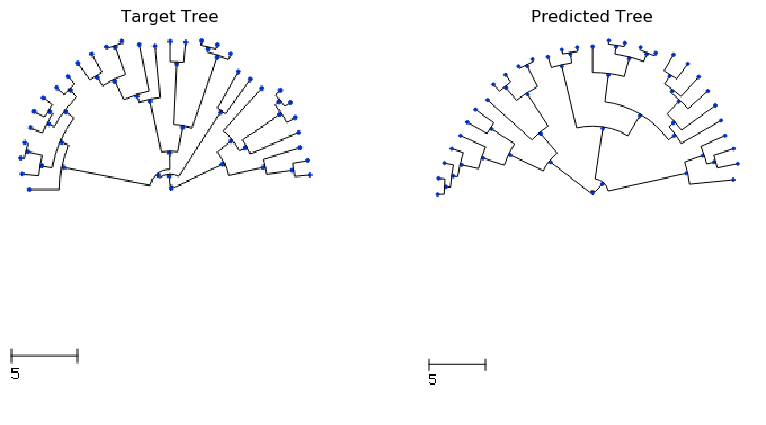

In [ ]:
from ete3 import Tree, faces, TreeStyle

# read the tree from the file
target_tree = Tree("target.nwk", format=1)
predicted_tree = Tree("predicted.nwk", format=1)

# render the target tree
ts = TreeStyle()
ts.show_leaf_name = False
ts.show_branch_length = False
ts.show_branch_support = False
ts.scale = 10
ts.mode = "c"
ts.arc_start = -180 # 0 degrees = 3 o'clock
ts.arc_span = 180

# save the trees as images
target_tree.render("target_tree.png", tree_style=ts)
predicted_tree.render("predicted_tree.png", tree_style=ts)

# plot the trees side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(Image.open("target_tree.png"))
ax[0].axis("off")
ax[0].set_title("Target Tree")
ax[1].imshow(Image.open("predicted_tree.png"))
ax[1].axis("off")
ax[1].set_title("Predicted Tree")
plt.show()



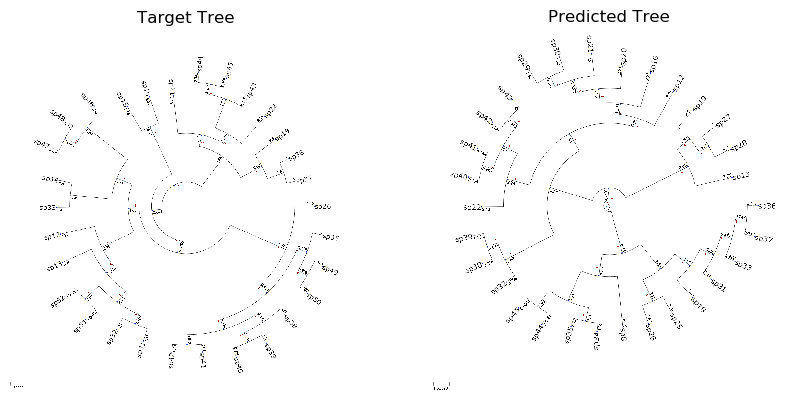

In [ ]:
import random
from ete3 import Tree, TreeStyle, NodeStyle, faces, AttrFace, CircleFace

def layout(node):
    if node.is_leaf():
        # Add node name to laef nodes
        N = AttrFace("name", fsize=14, fgcolor="black")
        faces.add_face_to_node(N, node, 0)
    if "weight" in node.features:
        # Creates a sphere face whose size is proportional to node's
        # feature "weight"
        C = CircleFace(radius=node.weight, color="RoyalBlue", style="sphere")
        # Let's make the sphere transparent
        C.opacity = 0.3
        # And place as a float face over the tree
        faces.add_face_to_node(C, node, 0, position="float")

def get_example_tree():
    # Random tree
    t = Tree()
    t.populate(20, random_branches=True)

    # Some random features in all nodes
    for n in t.traverse():
        n.add_features(weight=random.randint(0, 50))

    # Create an empty TreeStyle
    ts = TreeStyle()

    # Set our custom layout function
    ts.layout_fn = layout

    # Draw a tree
    ts.mode = "c"

    # We will add node names manually
    ts.show_leaf_name = False
    # Show branch data
    ts.show_branch_length = True
    ts.show_branch_support = True

    return t, ts

t, ts = get_example_tree()

# save the trees as images
target_tree.render("target_tree.png", tree_style=ts)
predicted_tree.render("predicted_tree.png", tree_style=ts)

# plot the trees side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(Image.open("target_tree.png"))
ax[0].axis("off")
ax[0].set_title("Target Tree")
ax[1].imshow(Image.open("predicted_tree.png"))
ax[1].axis("off")
ax[1].set_title("Predicted Tree")
plt.show()